<a href="https://colab.research.google.com/github/rreghunandan/Item-Demand-Forecasting/blob/main/Project_Item_Demand_Forecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
xgb=xgb.XGBRegressor()
from sklearn.metrics import r2_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('/content/train 2.csv',parse_dates=['date'])
df

date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]

In [3]:
print('Number of stores:',df['store'].nunique())
print('Number of items:',df['item'].nunique())

Number of stores: 10
Number of items: 50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [5]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [6]:
df.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [7]:
df.drop('store',axis=1,inplace=True)#dropping store col as as our problem statement focused on item demand but not on stores.

In [8]:
d1=df.groupby(['item','date'])['sales'].sum()#Grouping data based on item and date to get total sales of item on each day.

In [9]:
d2=d1.to_frame()#changing to dataframe


In [10]:
d2

sales
item date             
1    2013-01-01    133
     2013-01-02     99
     2013-01-03    127
     2013-01-04    145
     2013-01-05    149
...                ...
50   2017-12-27    511
     2017-12-28    587
     2017-12-29    596
     2017-12-30    612
     2017-12-31    626

[91300 rows x 1 columns]

In [11]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 91300 entries, (1, Timestamp('2013-01-01 00:00:00')) to (50, Timestamp('2017-12-31 00:00:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   91300 non-null  int64
dtypes: int64(1)
memory usage: 995.5 KB


In [12]:
d2.reset_index(inplace=True)
d2.set_index('date',inplace=True)

# EDA

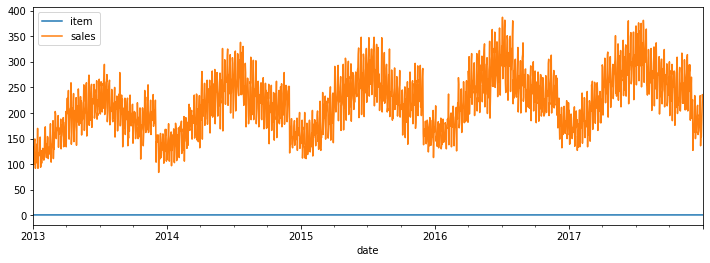

In [13]:
d2[d2['item']==1].plot(figsize=(12,4))#plotting item1 sales

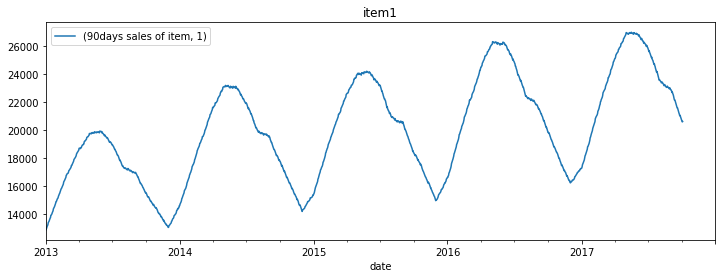

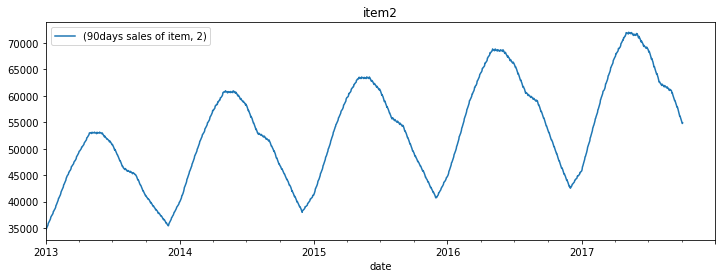

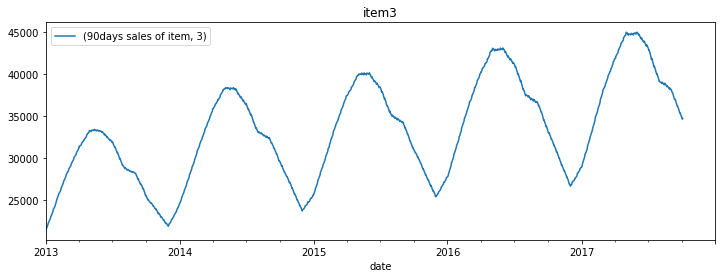

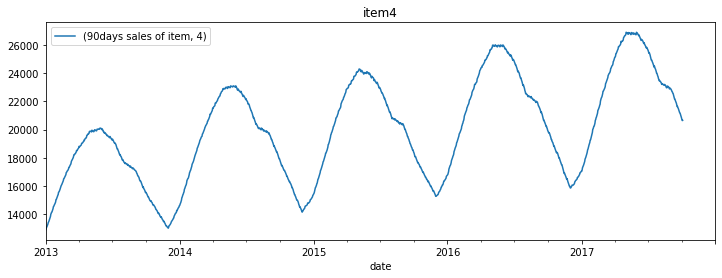

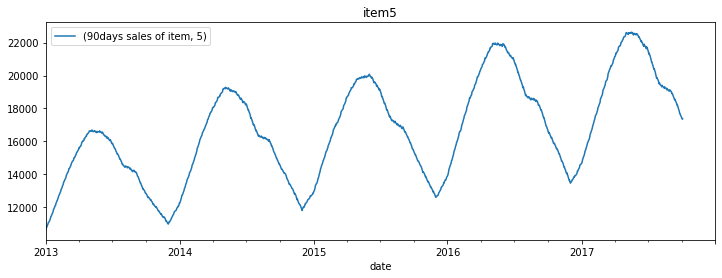

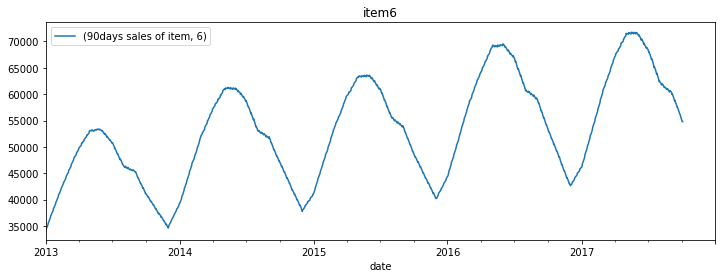

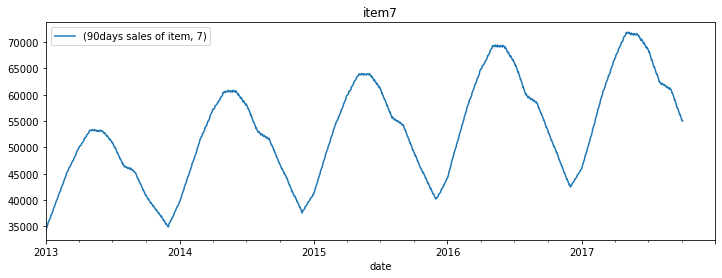

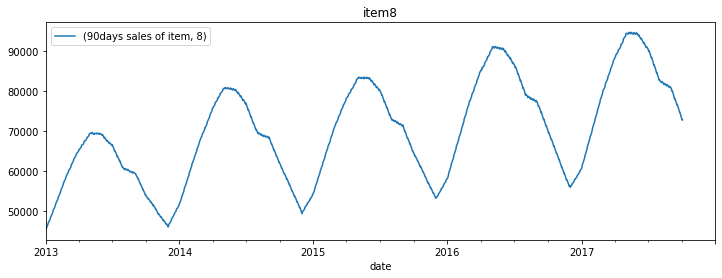

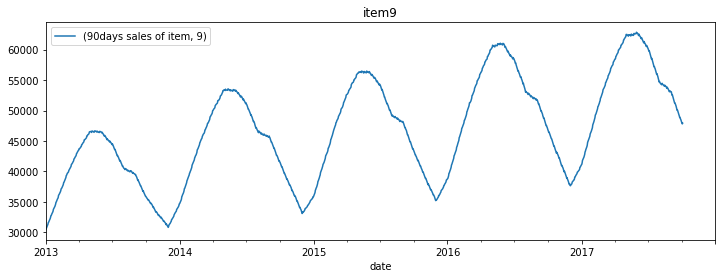

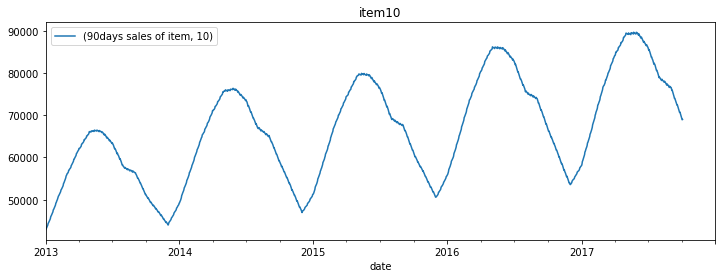

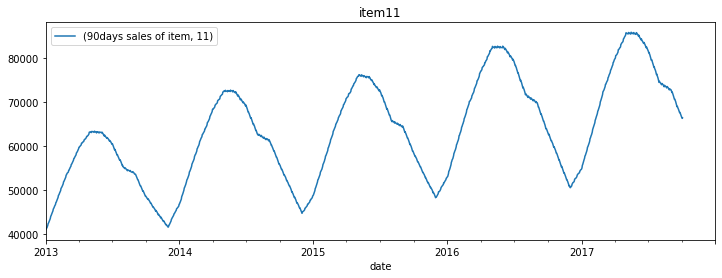

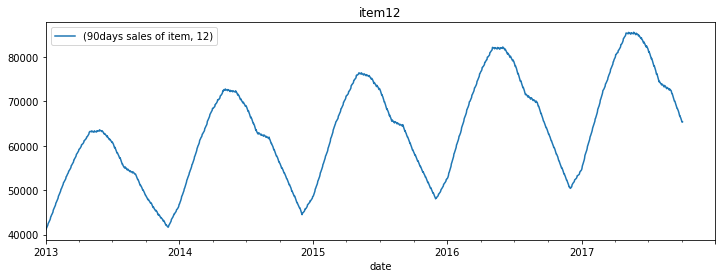

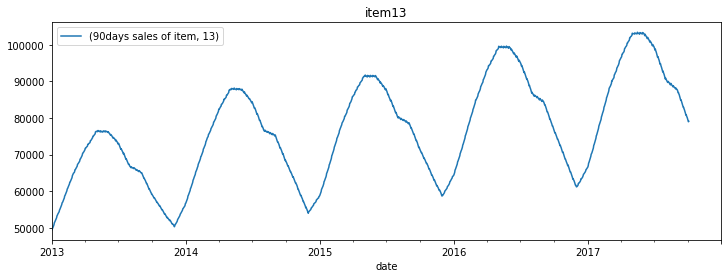

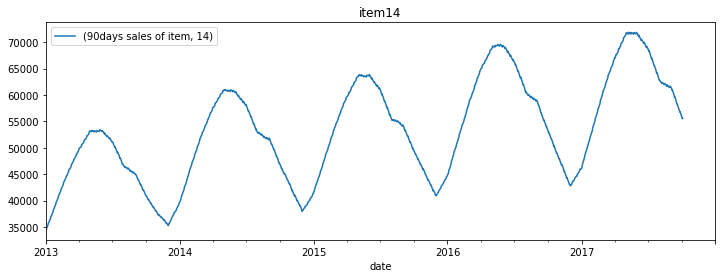

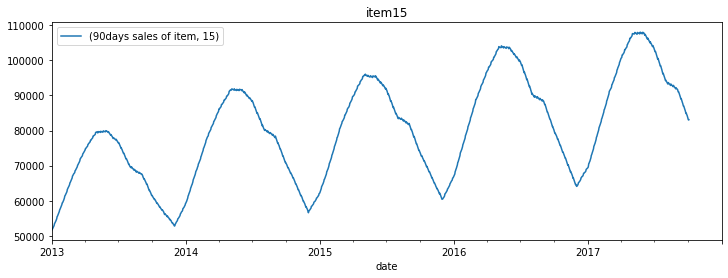

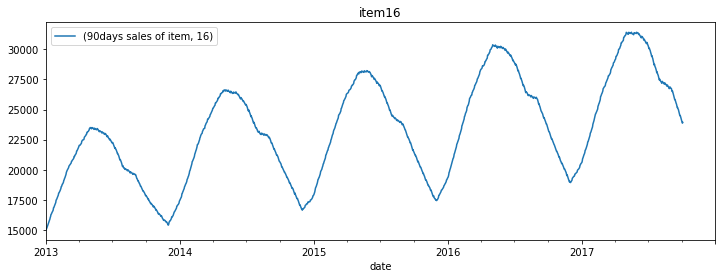

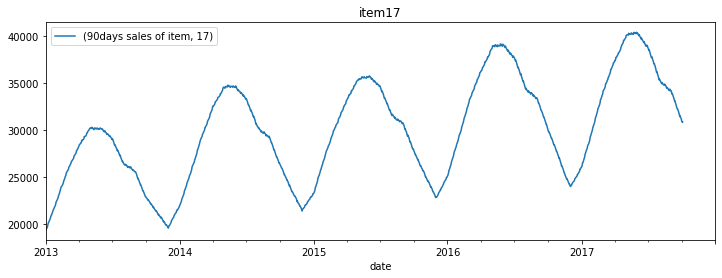

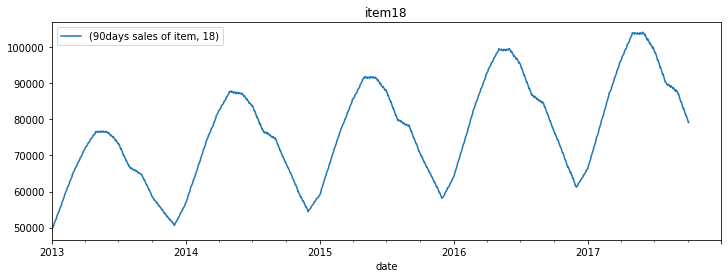

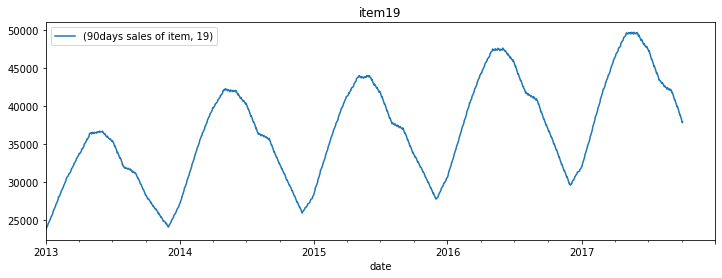

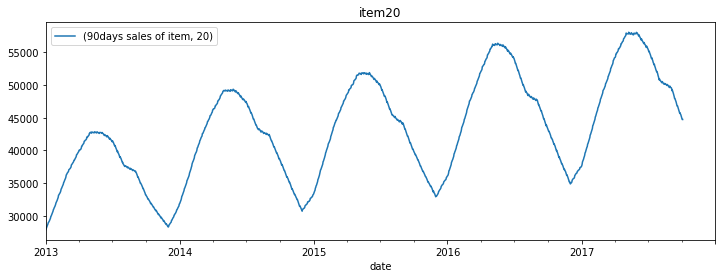

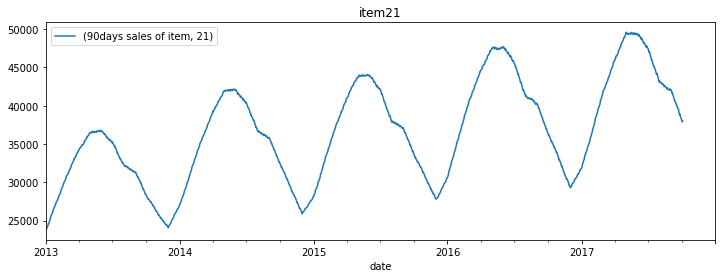

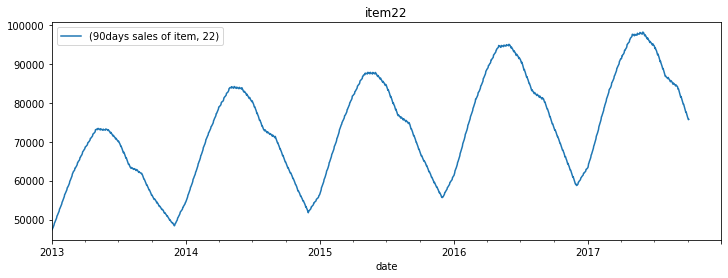

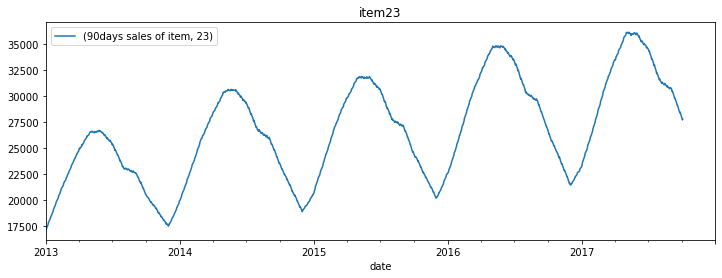

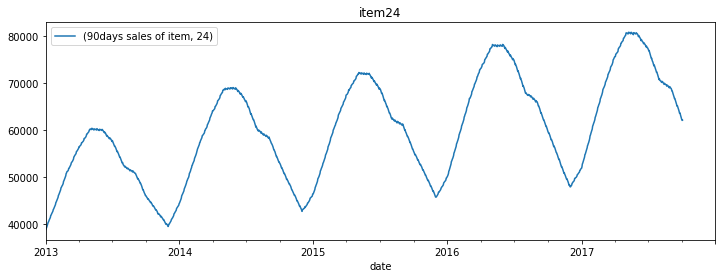

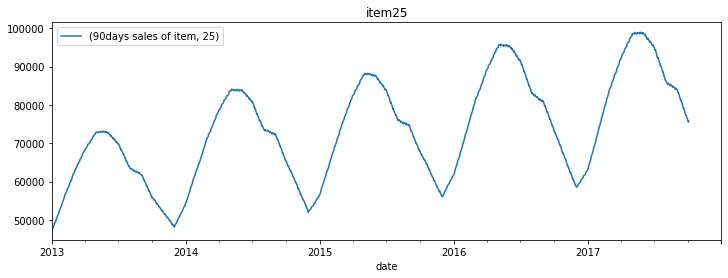

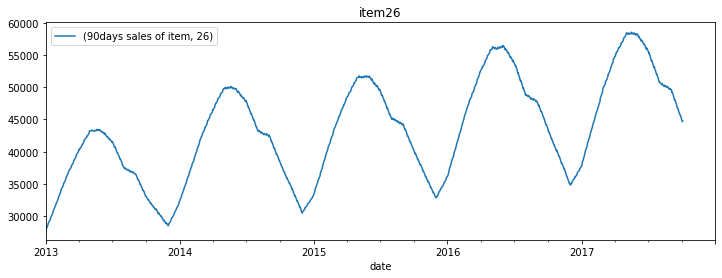

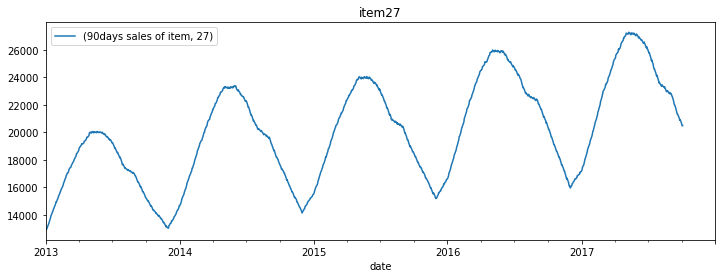

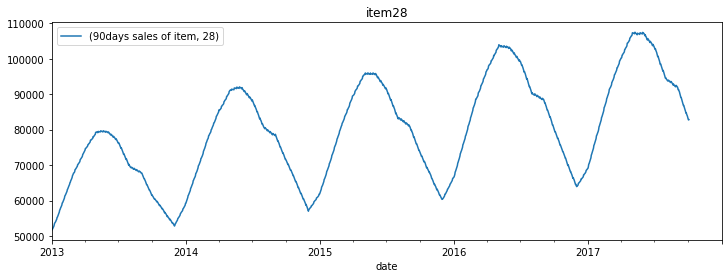

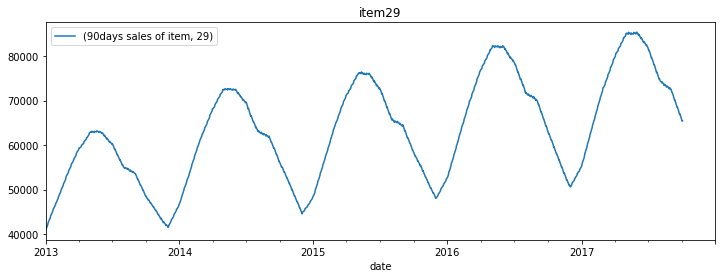

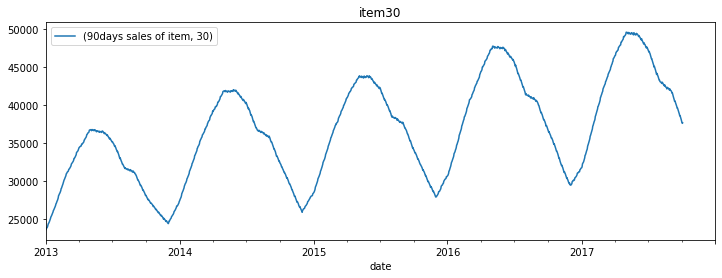

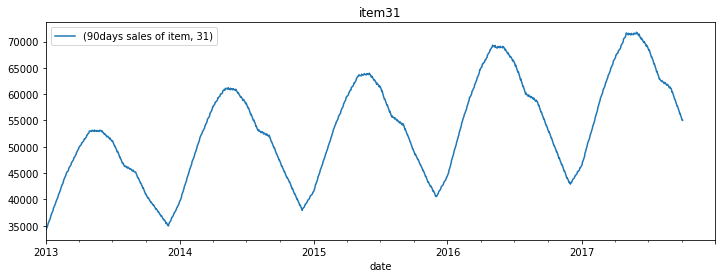

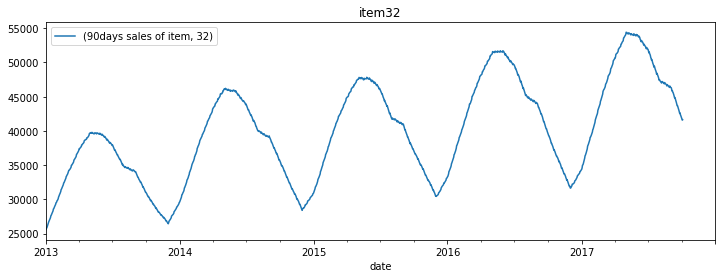

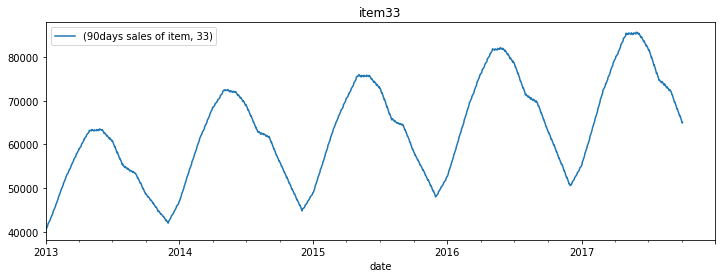

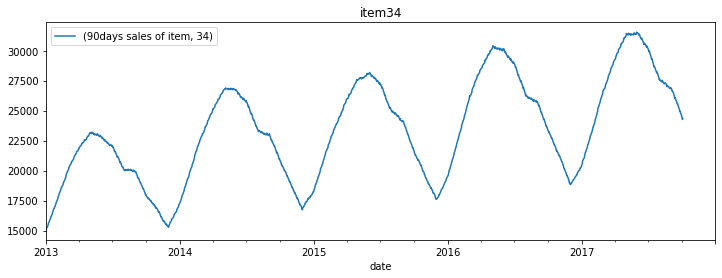

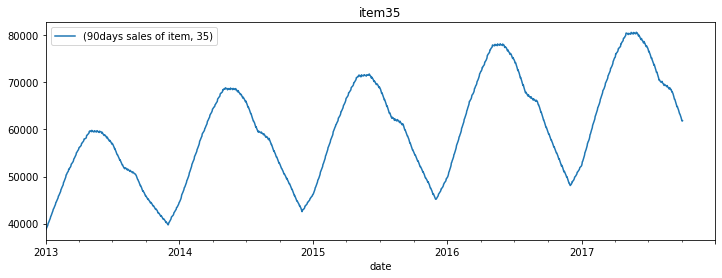

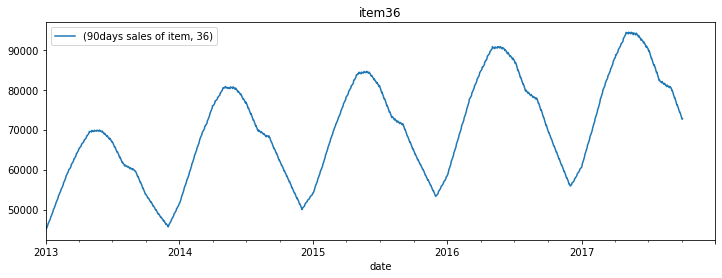

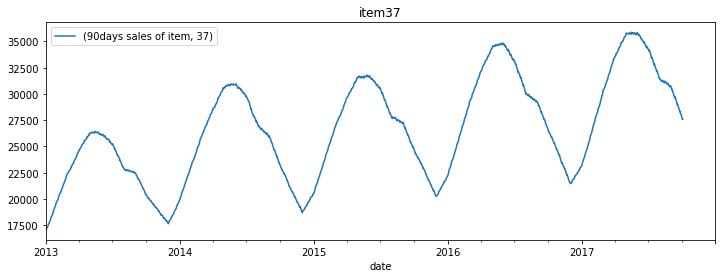

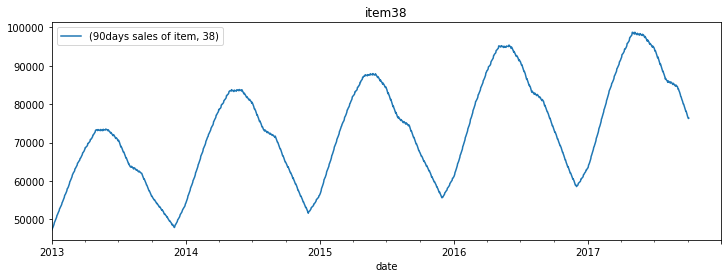

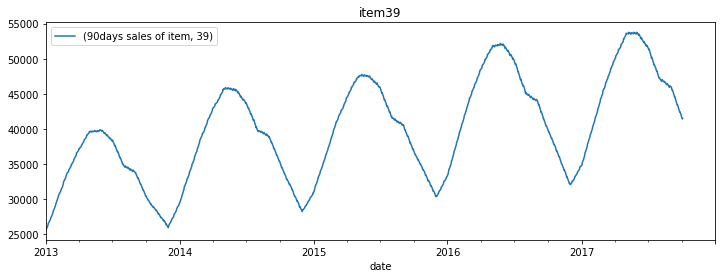

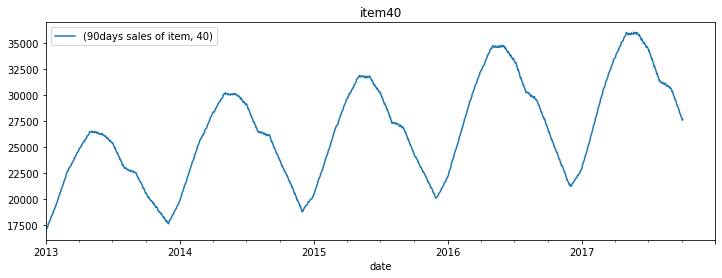

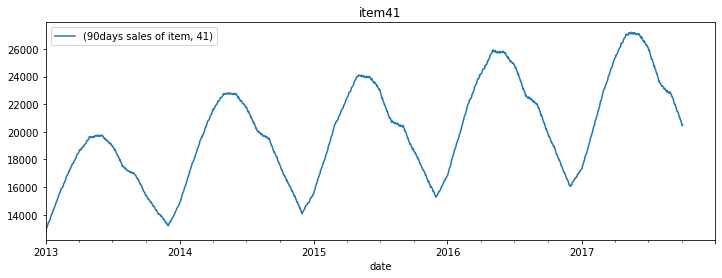

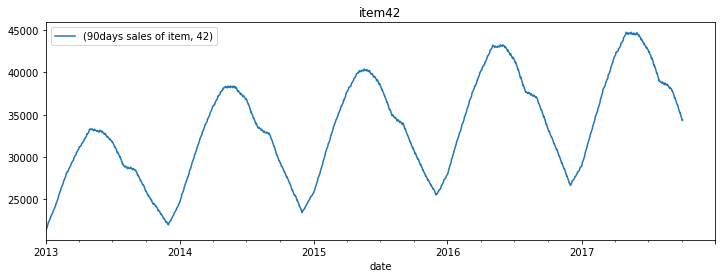

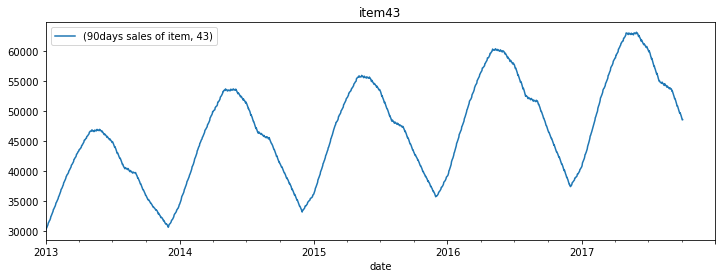

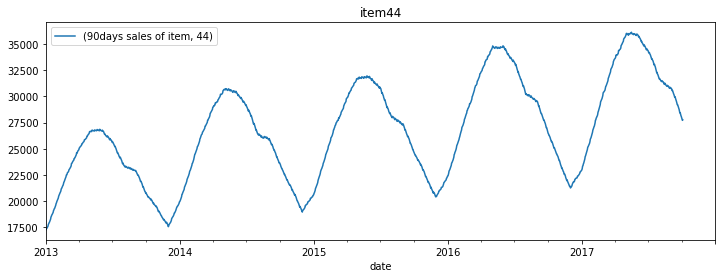

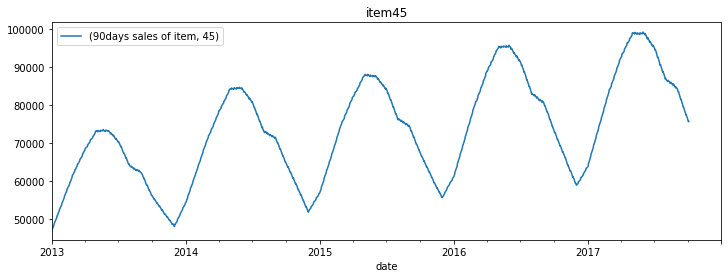

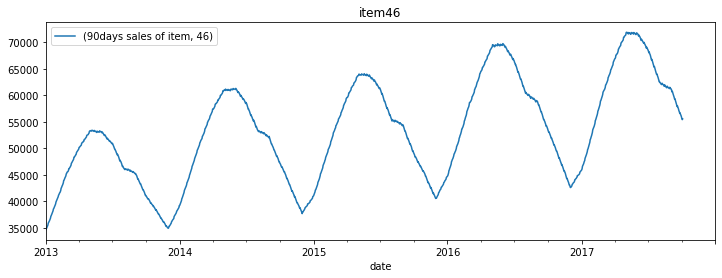

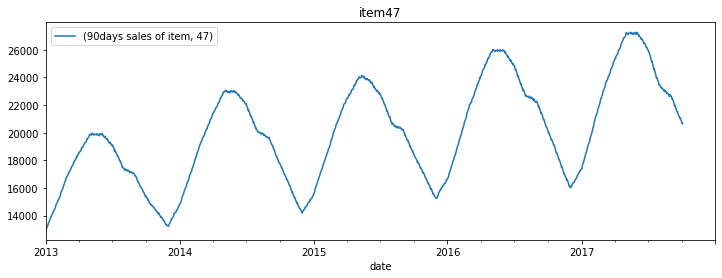

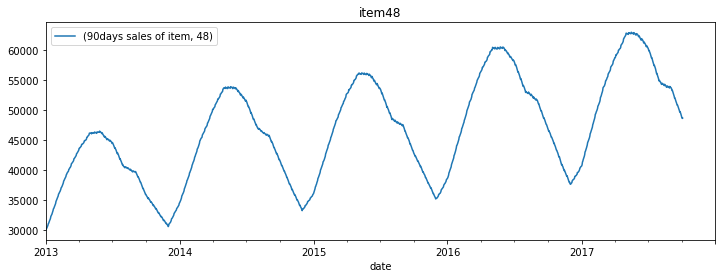

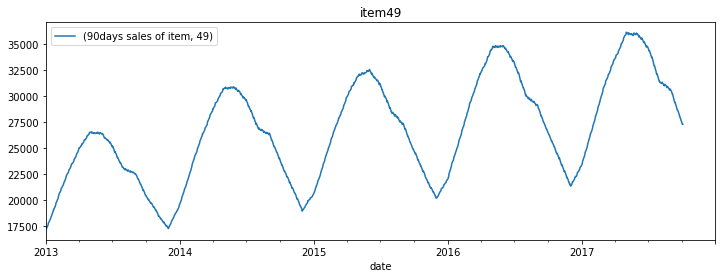

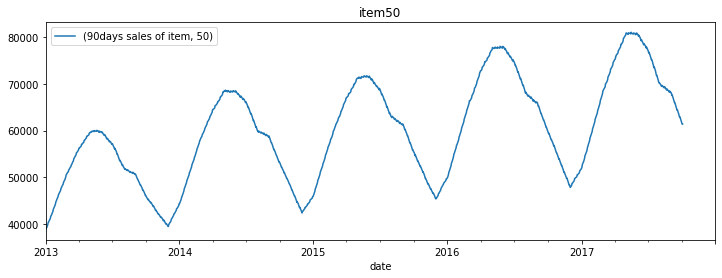

In [14]:
#90 day rolling sum of sales
for i in range(1,51):
    item=d2[d2['item']==i]
    item['90days sales of item',i]=item['sales'].rolling(90).sum().shift(-89)
    item.drop(['item','sales'],axis=1,inplace=True)
    item.plot(figsize=(12,4),title='item'+str(i))

1) There is a clear seasonality pattern => Month of the year is going to play a role => month is a feature
2) There is a clear trend over here => year s going to play a role
3) The demand is changing for eeach item over here => we will fit a model for each item

# Modelling Item 1

In [15]:
df_item1=d2[d2['item']==1]
df_item1['90day_sales']=df_item1['sales'].rolling(90).sum()
df_item1=df_item1.shift(-89)
df_item1=df_item1.iloc[::7]
df_item1.drop(['item','sales'],axis=1,inplace=True)

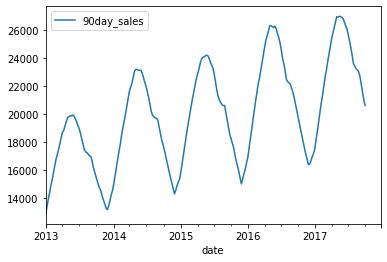

In [16]:
df_item1.plot()

In [17]:
df_item1.reset_index(inplace=True)

In [18]:
df_item1['day']=df_item1['date'].dt.day
df_item1['week']=df_item1['date'].dt.week
df_item1['year']=df_item1['date'].dt.year #taking day,week,year as features to predict the sales

In [19]:
df_item1.dropna(inplace=True)

In [20]:
df_item1.set_index('date',inplace=True)

In [21]:
X_train=df_item1.drop(['90day_sales'],axis=1).iloc[:200]
X_test=df_item1.drop(['90day_sales'],axis=1).iloc[200:]

Y_train=df_item1['90day_sales'].iloc[:200]
Y_test=df_item1['90day_sales'].iloc[200:]#making train and test datasets

In [22]:
X_test

day  week  year
date                       
2016-11-01    1    44  2016
2016-11-08    8    45  2016
2016-11-15   15    46  2016
2016-11-22   22    47  2016
2016-11-29   29    48  2016
2016-12-06    6    49  2016
2016-12-13   13    50  2016
2016-12-20   20    51  2016
2016-12-27   27    52  2016
2017-01-03    3     1  2017
2017-01-10   10     2  2017
2017-01-17   17     3  2017
2017-01-24   24     4  2017
2017-01-31   31     5  2017
2017-02-07    7     6  2017
2017-02-14   14     7  2017
2017-02-21   21     8  2017
2017-02-28   28     9  2017
2017-03-07    7    10  2017
2017-03-14   14    11  2017
2017-03-21   21    12  2017
2017-03-28   28    13  2017
2017-04-04    4    14  2017
2017-04-11   11    15  2017
2017-04-18   18    16  2017
2017-04-25   25    17  2017
2017-05-02    2    18  2017
2017-05-09    9    19  2017
2017-05-16   16    20  2017
2017-05-23   23    21  2017
2017-05-30   30    22  2017
2017-06-06    6    23  2017
2017-06-13   13    24  2017
2017-06-20   20    25  2017
2017-06-27   27    26  2017
2017-07-04    4    27  2017
2017-07-11   11    28  2017
2017-07-18   18    29  2017
2017-07-25   25    30  2017
2017-08-01    1    31  2017
2017-08-08    8    32  2017
2017-08-15   15    33  2017
2017-08-22   22    34  2017
2017-08-29   29    35  2017
2017-09-05    5    36  2017
2017-09-12   12    37  2017
2017-09-19   19    38  2017
2017-09-26   26    39  2017
2017-10-03    3    40  2017

# ML Model Prediction

In [23]:
def predict_plot(model,title):
    model.fit(X_train,Y_train)
    pred=model.predict(X_test)
    yt=Y_test.to_frame()
    yt['prediction']=pred
    yt.plot(ylabel='sales',title=title)
    print('The r2 score achieved using '+title+' is',r2_score(Y_test,pred))

The r2 score achieved using LinearRegression is 0.15886231040197052
The r2 score achieved using RandomForest is 0.9381285848064459
The r2 score achieved using DecisionTree is 0.9398719679040543
[09:00:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The r2 score achieved using XGBoost is 0.9443150212114102


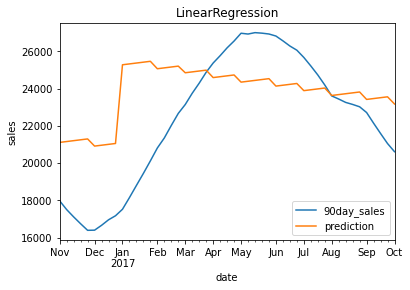

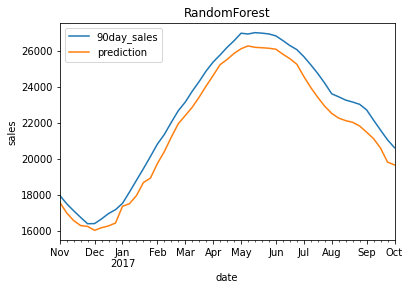

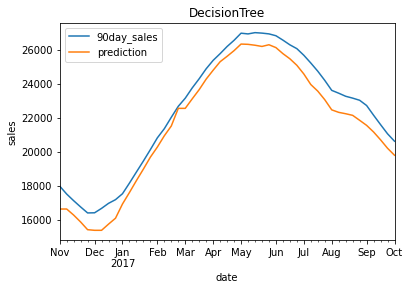

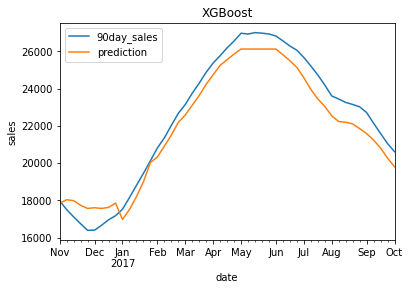

In [24]:
predict_plot(LinearRegression(),'LinearRegression')
predict_plot(RandomForestRegressor(),'RandomForest')
predict_plot(DecisionTreeRegressor(),'DecisionTree')
predict_plot(xgb,'XGBoost')

In [25]:
p=[30,17,2022]
p =np.array(p).reshape((1,-1))
p = pd.DataFrame(p,columns = ['day', 'week', 'year'])

print('The predicted next 90day sales are ',xgb.predict(p))#prediction for 15-11-2016 using xgb

The predicted next 90day sales are  [25847.334]


In [26]:
p = pd.DataFrame(p,columns = ['day', 'week', 'year'])

## Out of Sample Prediction


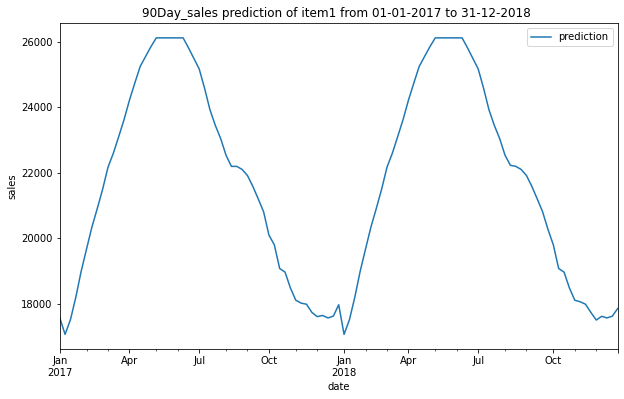

In [27]:
t=str('2017-01-01')#setting start date as 01-01-2017
datelist = pd.date_range(datetime.fromisoformat(t).date(), periods=730).tolist()#setting end date as 31-12-2018
forecast=pd.DataFrame({'date':datelist})#converting datelist to dataframe
forecast['p']=forecast['date'].apply(lambda x:[x.day,x.isocalendar()[1],x.year])#extracting day,week and year features from date
forecast=forecast.iloc[::7]
forecast['r']=forecast['p'].apply(lambda x:np.array(x).reshape((1,-1)))
forecast['prediction']=forecast['r'].apply(lambda x:xgb.predict(pd.DataFrame(x, columns = ['day', 'week', 'year'])))#prediction done using XGBoost model
forecast.set_index('date',inplace=True)
forecast['prediction']=forecast['prediction'].apply(lambda x:int(x))#making prediction column from object type to int type.
forecast.plot(figsize=(10,6),ylabel='sales',title='90Day_sales prediction of item1 from 01-01-2017 to 31-12-2018 ')

In [28]:
list(zip(xgb.feature_importances_,['day', 'week', 'year']))

[(0.004765436, 'day'), (0.31751505, 'week'), (0.6777195, 'year')]

## In sample Prediction

In [29]:
x1=df_item1.drop(['90day_sales'],axis=1).iloc[:53]#taken data of 2013-2014
x2=df_item1.drop(['90day_sales'],axis=1).iloc[105:157]#taken data of 2015-2016
X_train=pd.concat([x1,x2],axis=0)#merged x1 and x2
X_test=df_item1.drop(['90day_sales'],axis=1).iloc[53:105]#taken data of 2014-2015
y1=df_item1['90day_sales'].iloc[:53]#taken data of 2013-2014
y2=df_item1['90day_sales'].iloc[105:157]#taken data of 2015-2016
Y_train=pd.concat([y1,y2],axis=0)#merged y1 and y2
Y_test=df_item1['90day_sales'].iloc[53:105]#taken data of 2014-2015
print('x_traing data',X_train,sep='\n')
print('x_test data',X_test,sep='\n')

x_traing data
            day  week  year
date                       
2013-01-01    1     1  2013
2013-01-08    8     2  2013
2013-01-15   15     3  2013
2013-01-22   22     4  2013
2013-01-29   29     5  2013
...         ...   ...   ...
2015-12-01    1    49  2015
2015-12-08    8    50  2015
2015-12-15   15    51  2015
2015-12-22   22    52  2015
2015-12-29   29    53  2015

[105 rows x 3 columns]
x_test data
            day  week  year
date                       
2014-01-07    7     2  2014
2014-01-14   14     3  2014
2014-01-21   21     4  2014
2014-01-28   28     5  2014
2014-02-04    4     6  2014
2014-02-11   11     7  2014
2014-02-18   18     8  2014
2014-02-25   25     9  2014
2014-03-04    4    10  2014
2014-03-11   11    11  2014
2014-03-18   18    12  2014
2014-03-25   25    13  2014
2014-04-01    1    14  2014
2014-04-08    8    15  2014
2014-04-15   15    16  2014
2014-04-22   22    17  2014
2014-04-29   29    18  2014
2014-05-06    6    19  2014
2014-05-13   13    20  201

[09:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The r2 score achieved using XGBoost is 0.8877352665598769


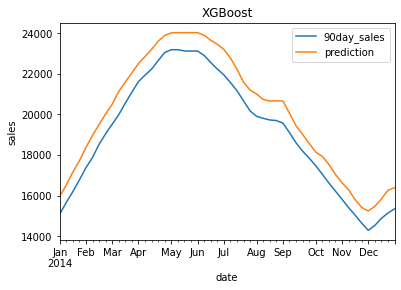

In [30]:
predict_plot(xgb,'XGBoost')

## Finding best model for all the items

In [31]:
l=[]
r2=[]
best=[]
models=["LinearRegression","RandomForest","DecisionTree","XGBoost"]

In [32]:
def predict_plot(model,title):
    model.fit(X_train,Y_train)
    pred=model.predict(X_test)
    yt=Y_test.to_frame()
    yt['prediction']=pred
    yt.plot(ylabel='sales',title=title)
    r2.append(r2_score(Y_test,pred))
    l.append(model)
    #print('The r2 score achieved using '+title+' is',r2_score(Y_test,pred))

[09:00:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best r2_score for item1 achieved using XGBoost and score is 0.9443150212114102
[09:00:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best r2_score for item2 achieved using DecisionTree and score is 0.940574734844005
[09:00:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best r2_score for item3 achieved using DecisionTree and score is 0.9282030733881231
[09:00:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best r2_score for item4 achieved using DecisionTree and score is 0.9515881098472185
[09:00:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best r2_score f

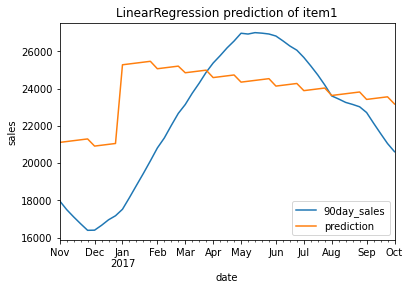

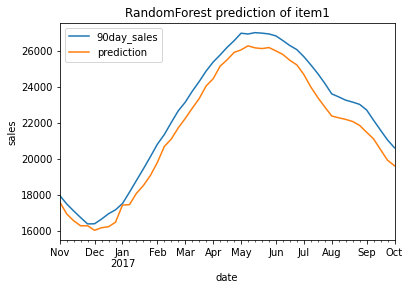

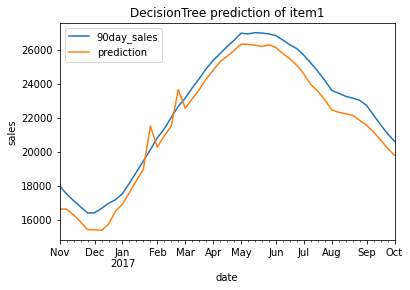

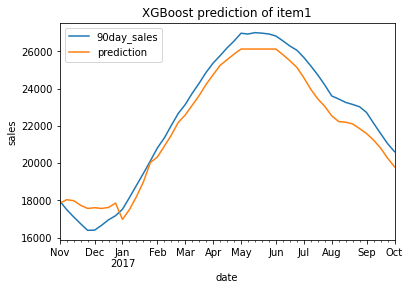

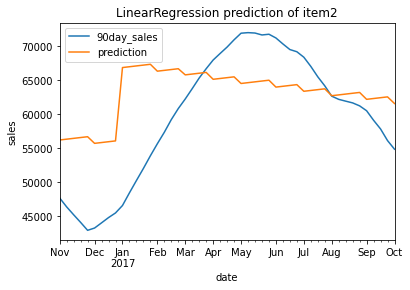

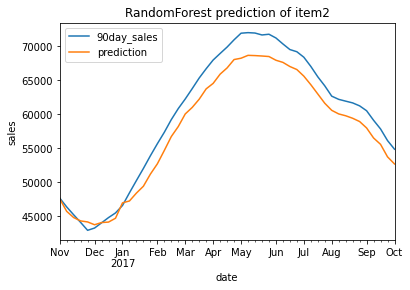

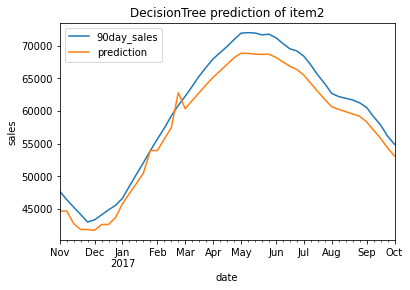

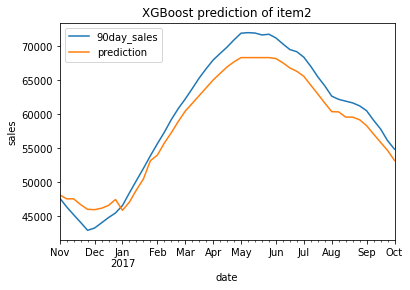

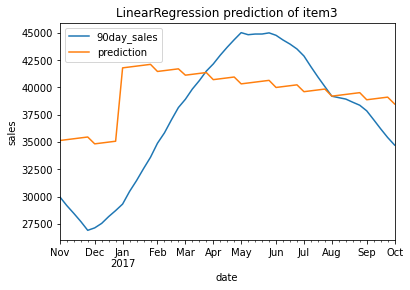

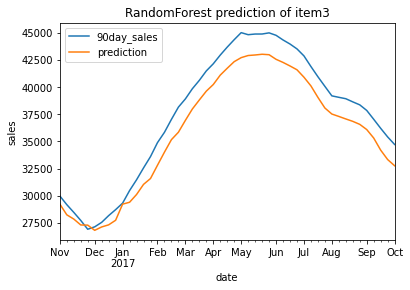

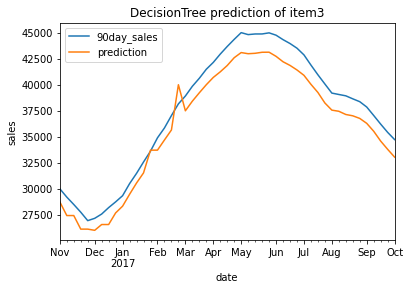

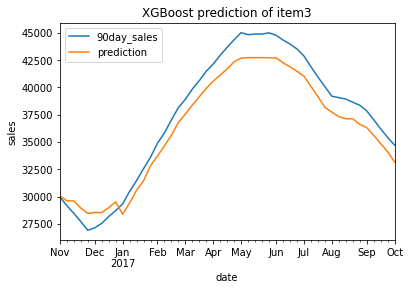

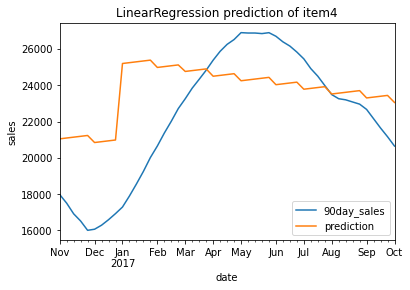

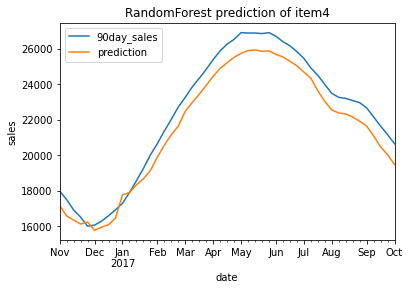

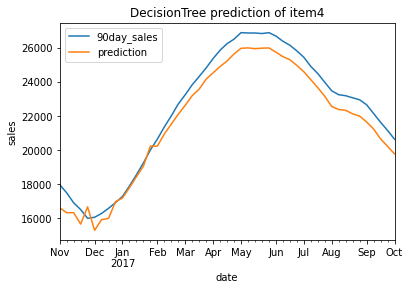

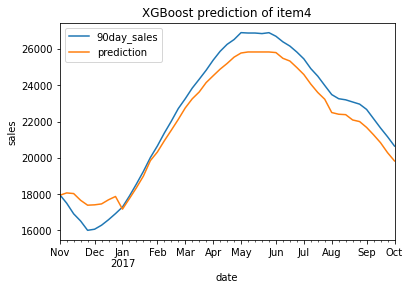

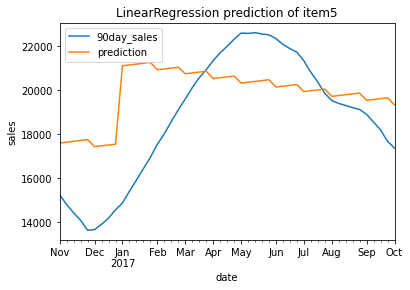

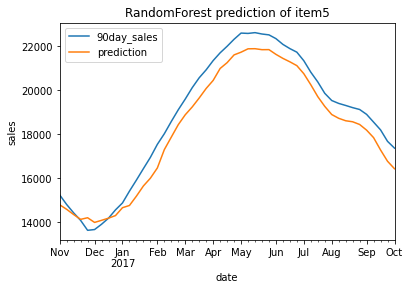

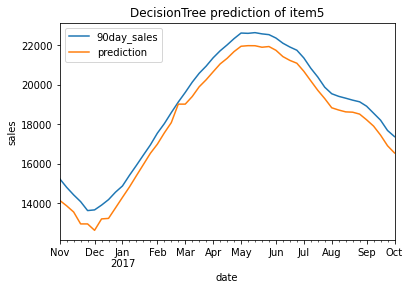

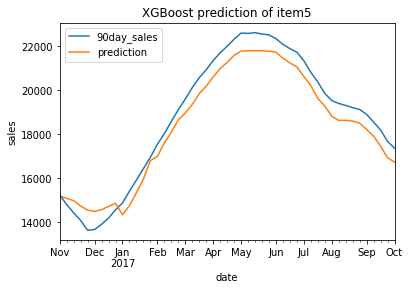

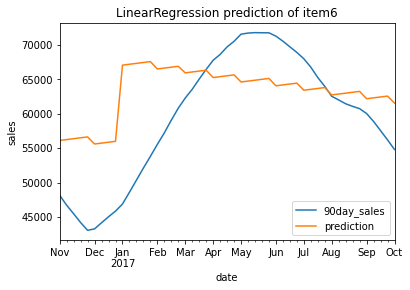

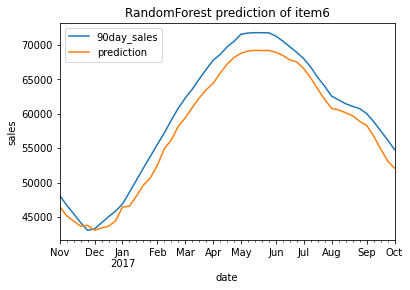

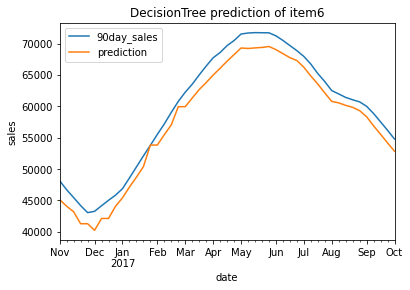

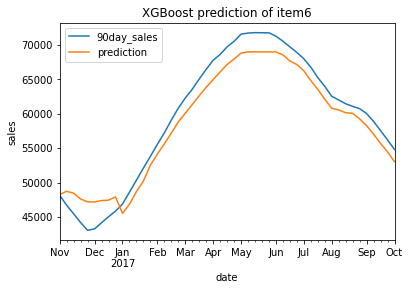

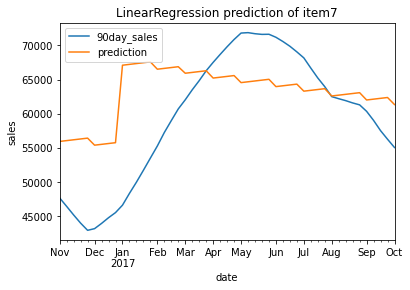

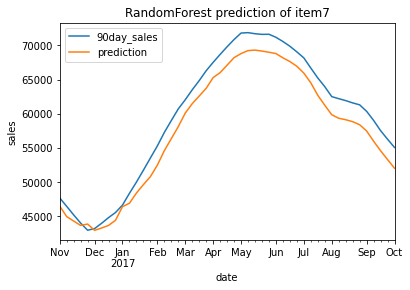

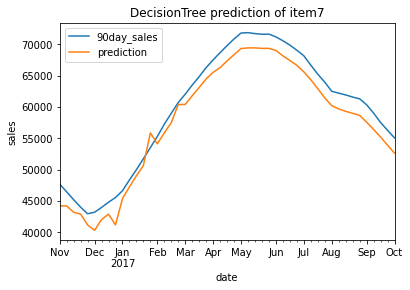

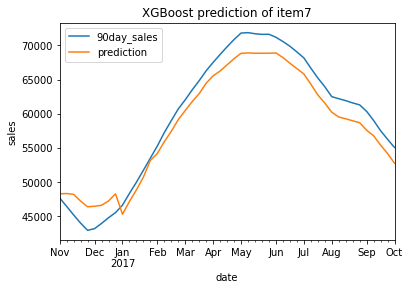

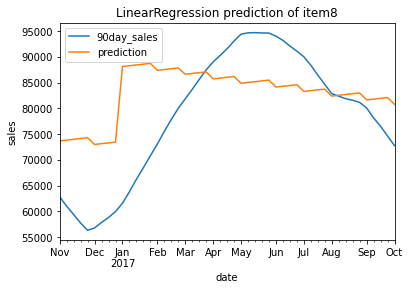

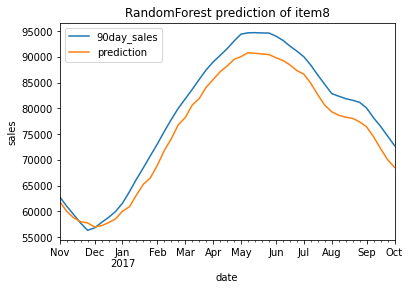

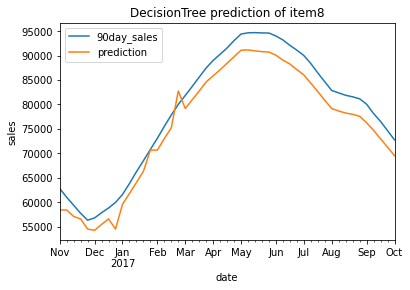

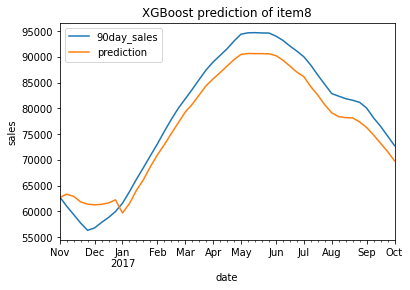

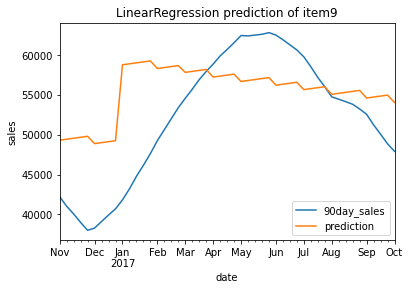

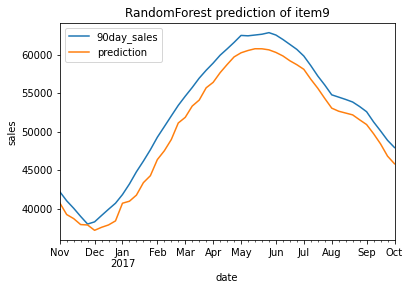

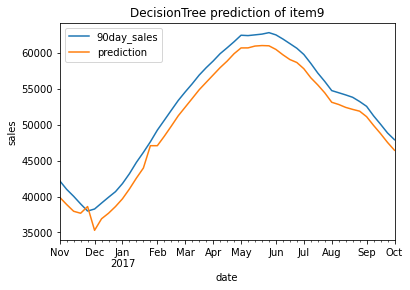

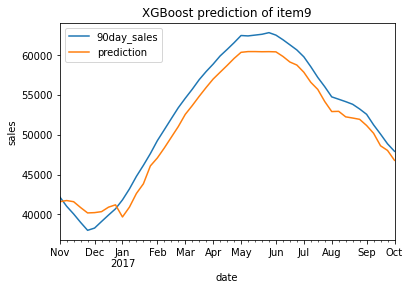

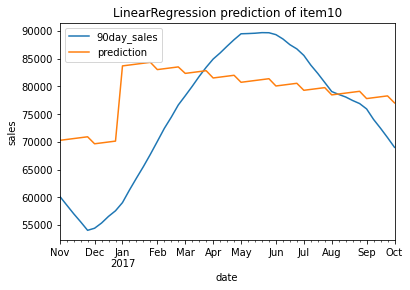

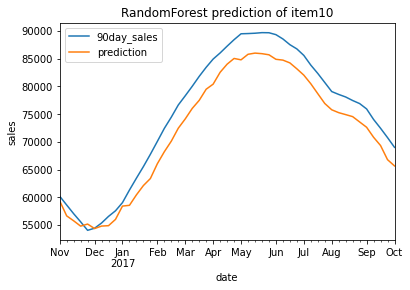

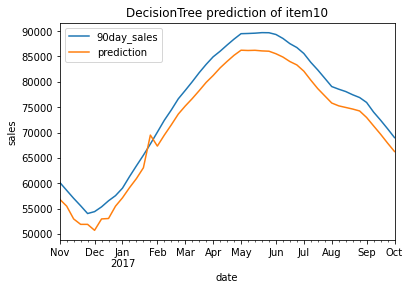

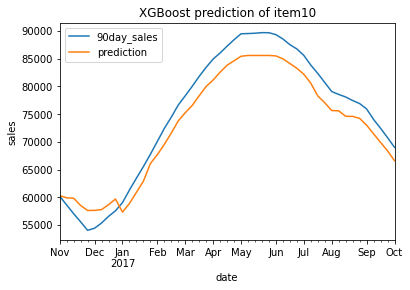

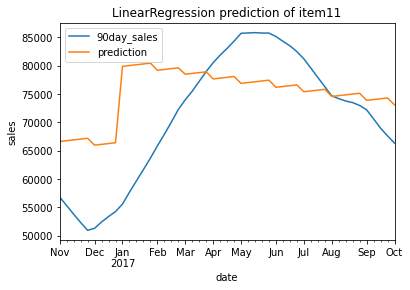

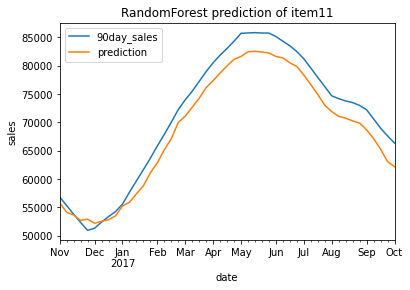

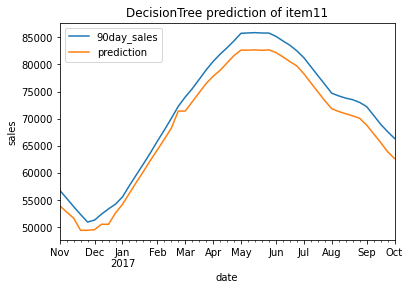

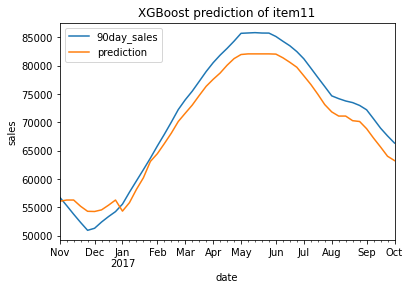

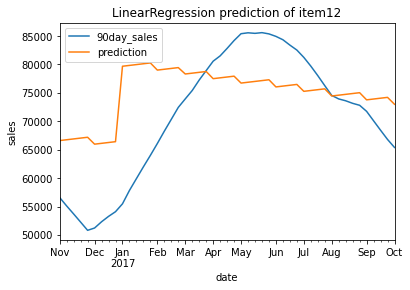

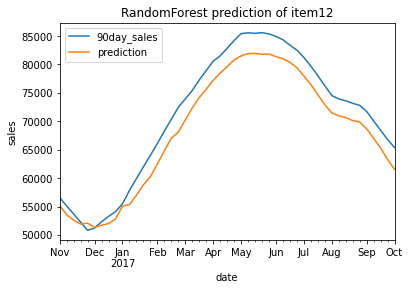

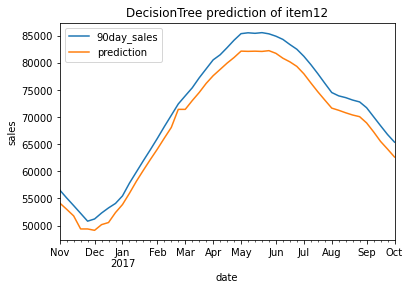

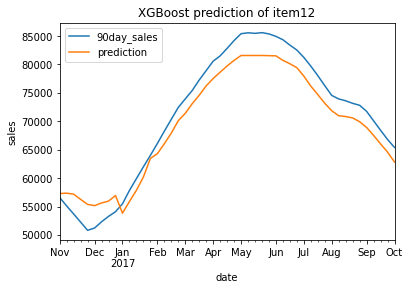

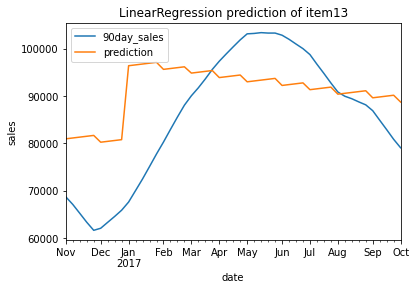

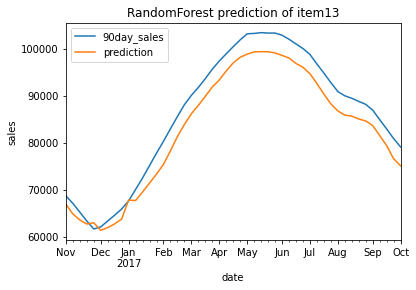

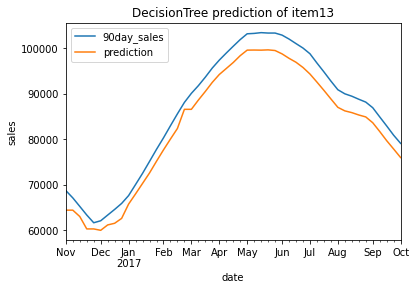

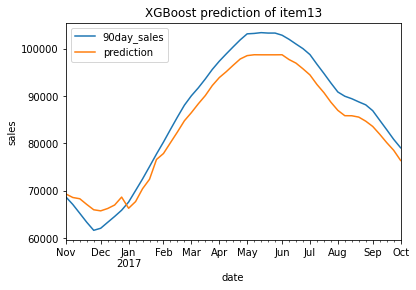

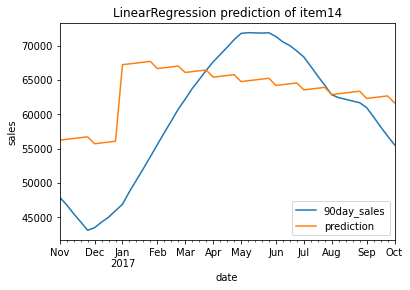

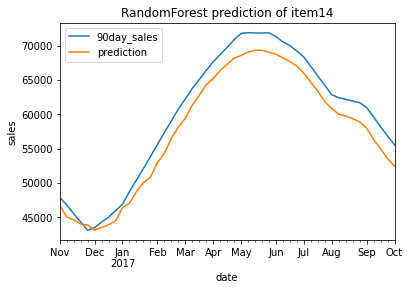

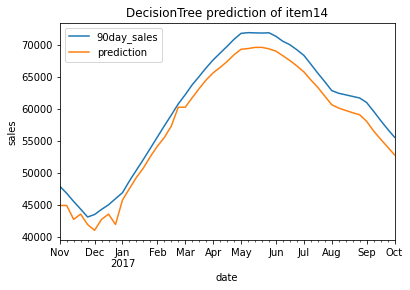

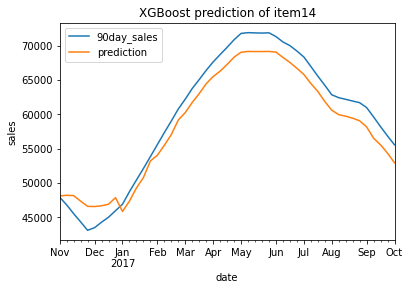

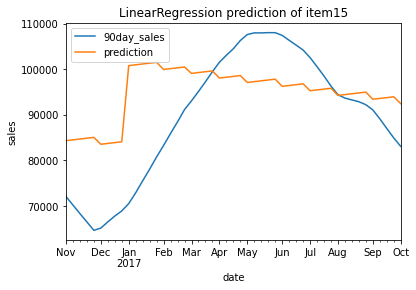

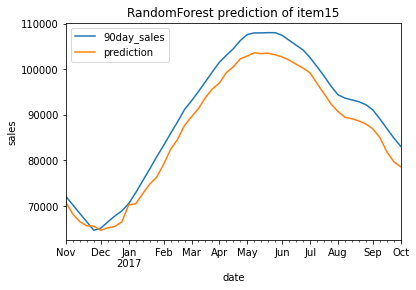

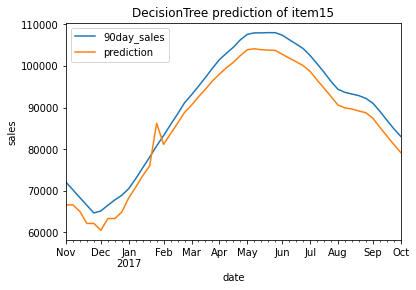

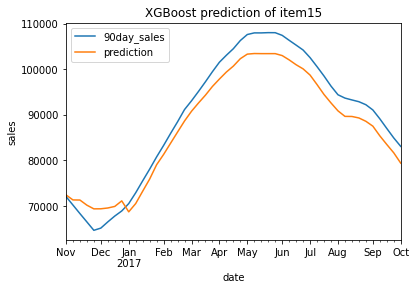

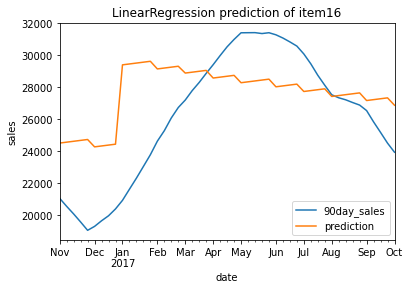

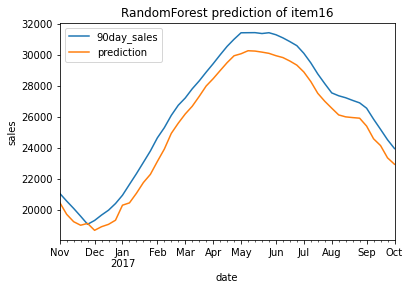

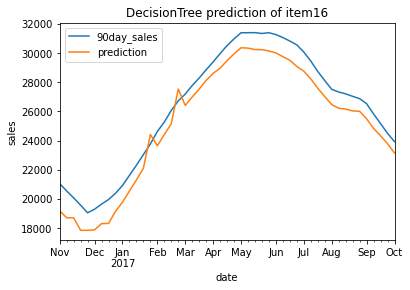

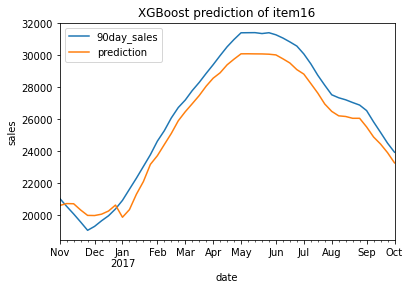

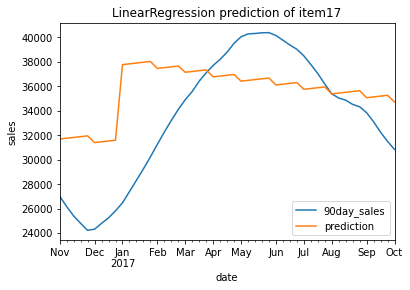

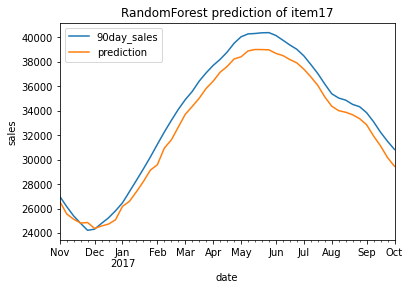

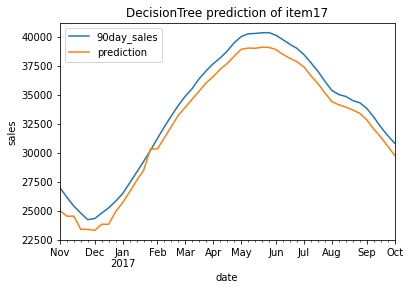

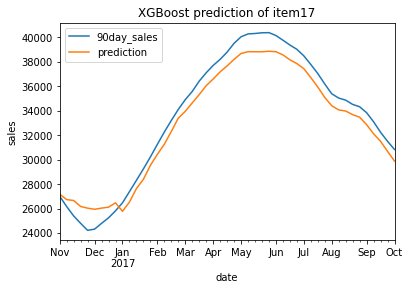

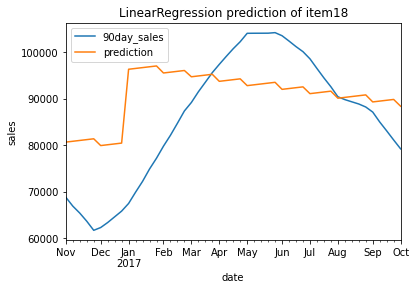

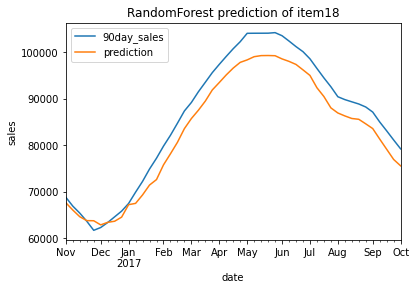

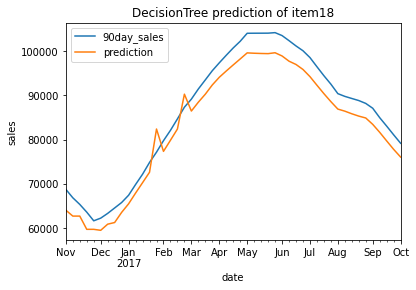

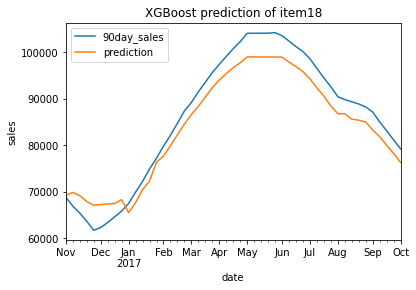

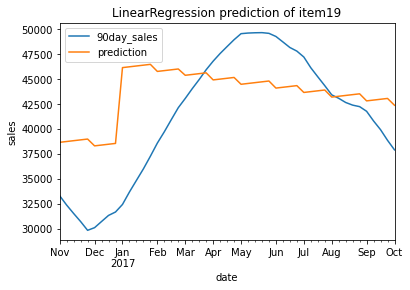

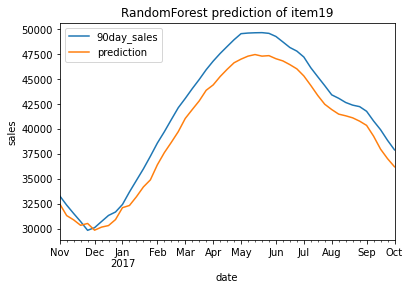

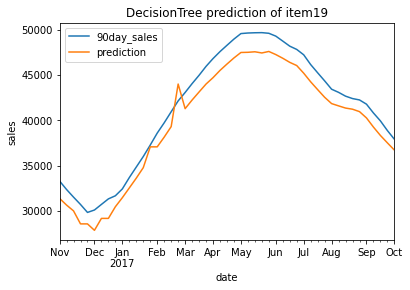

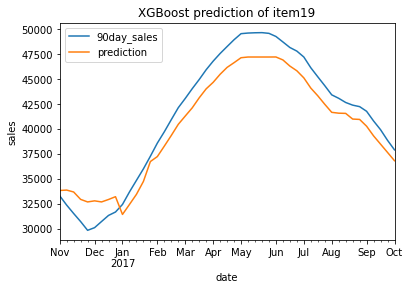

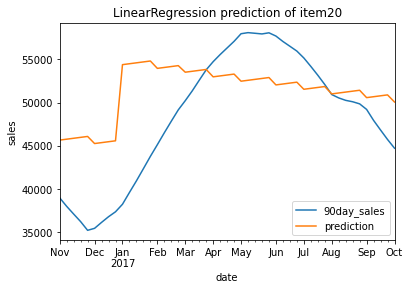

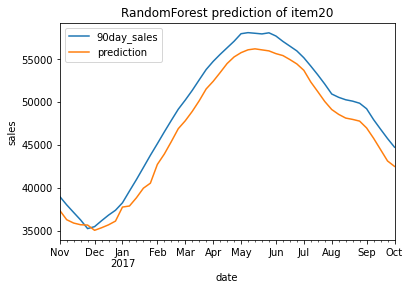

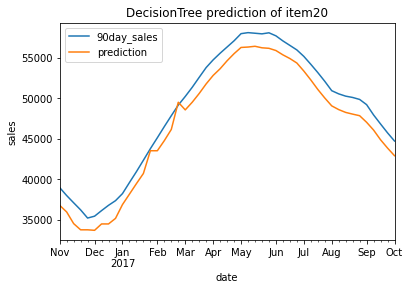

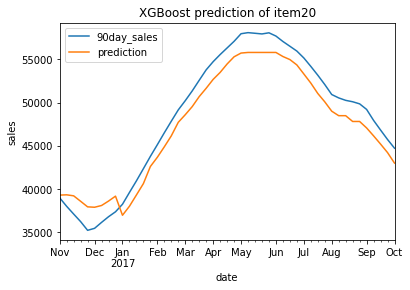

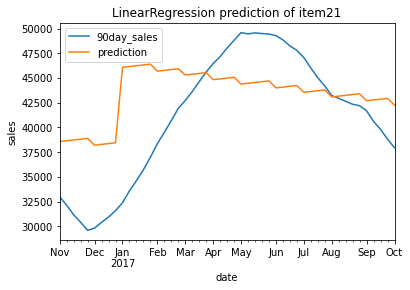

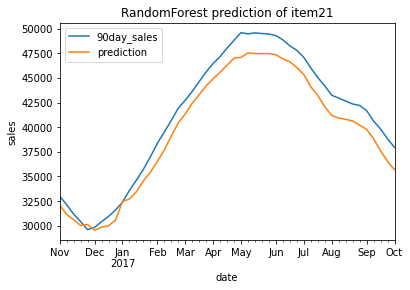

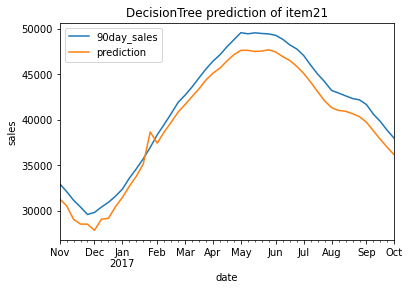

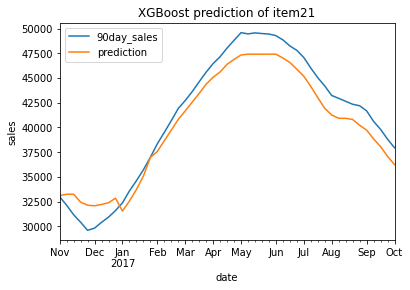

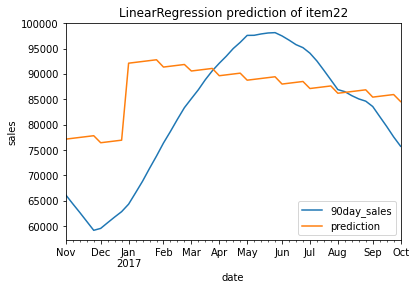

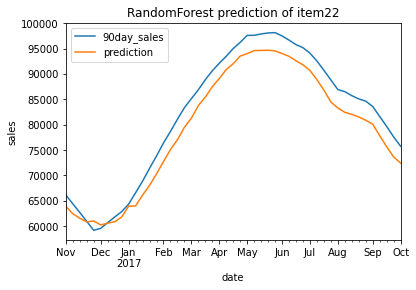

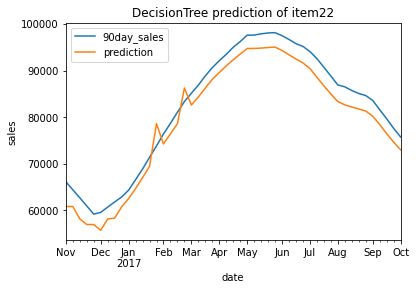

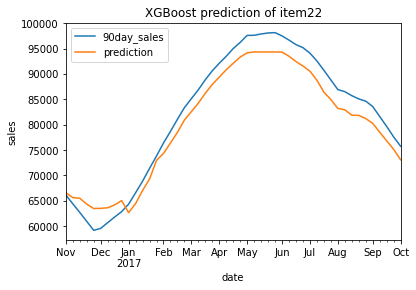

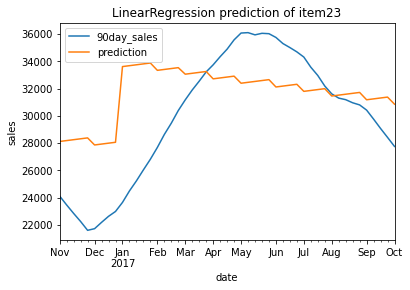

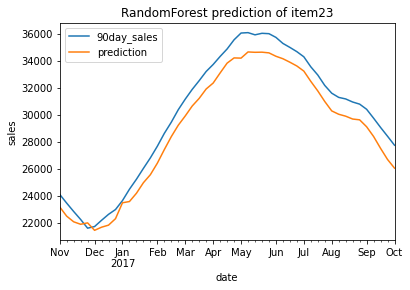

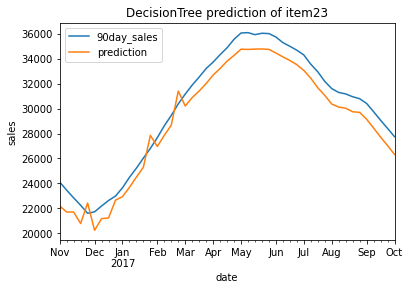

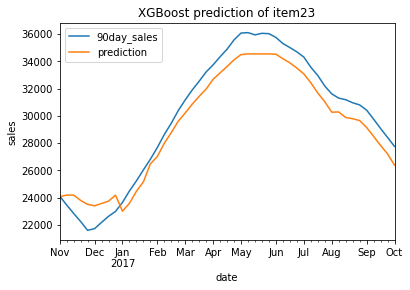

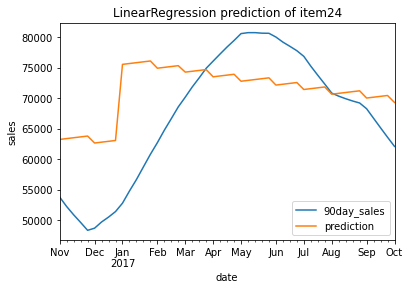

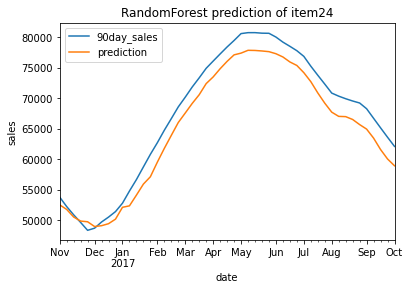

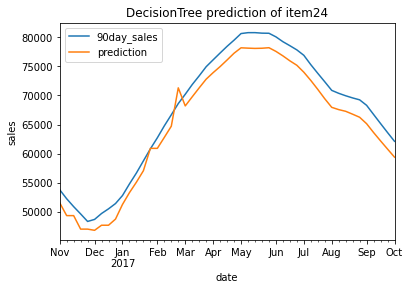

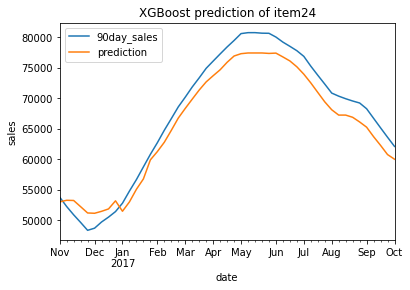

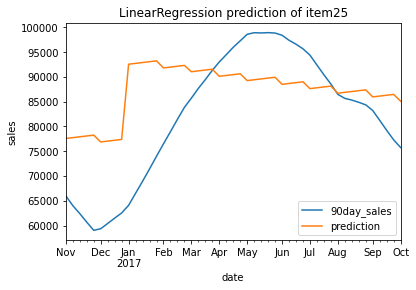

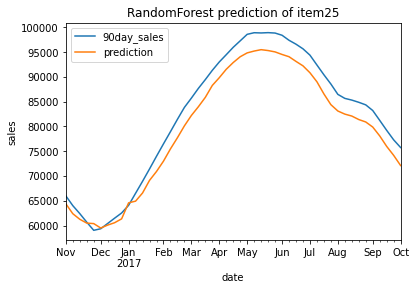

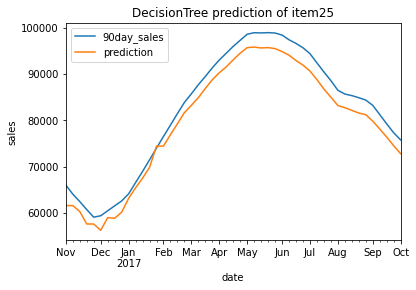

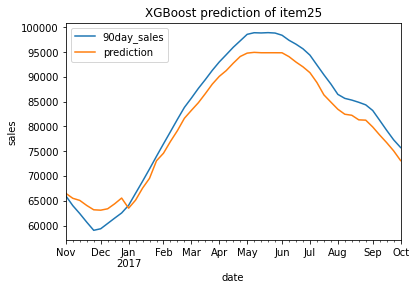

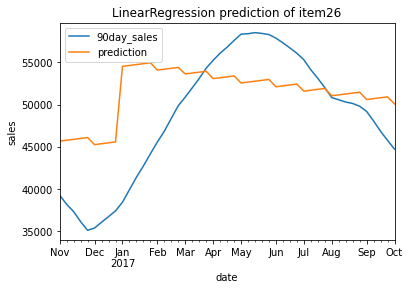

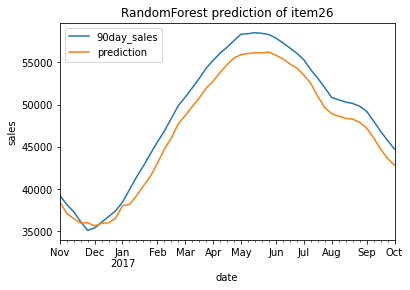

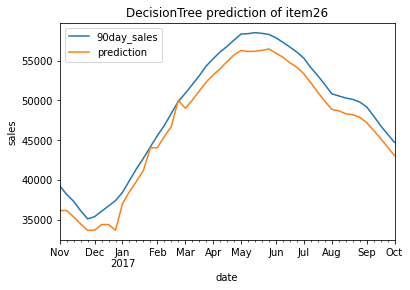

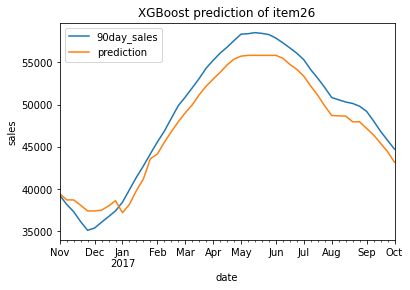

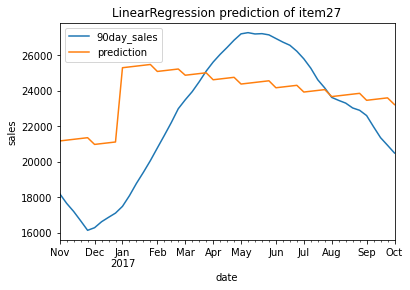

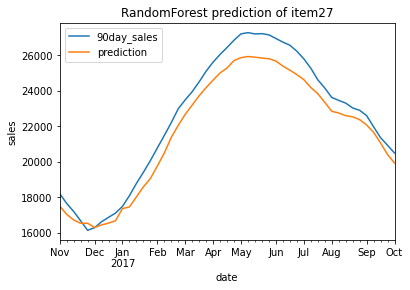

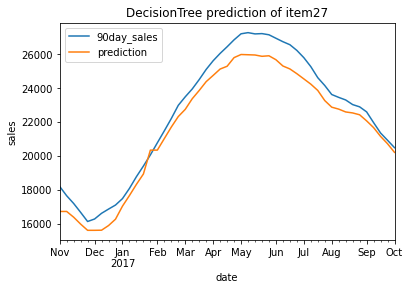

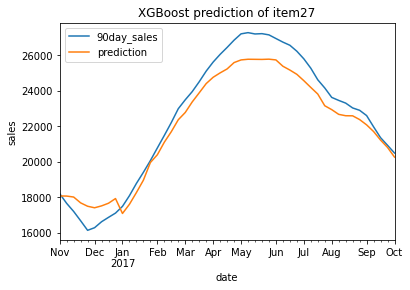

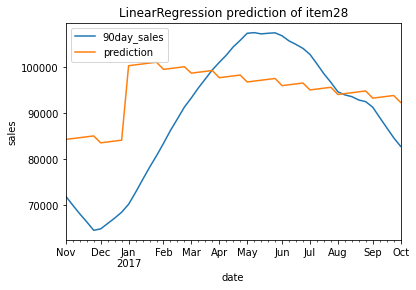

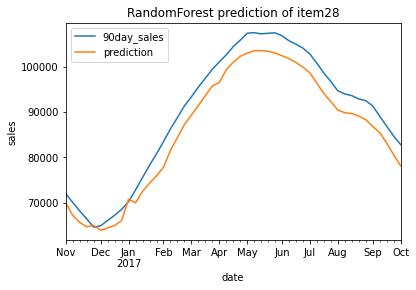

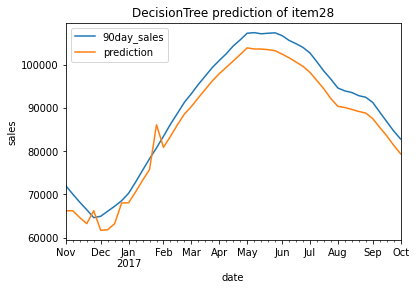

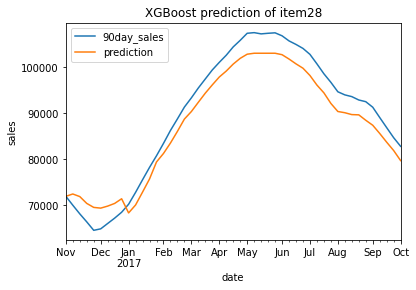

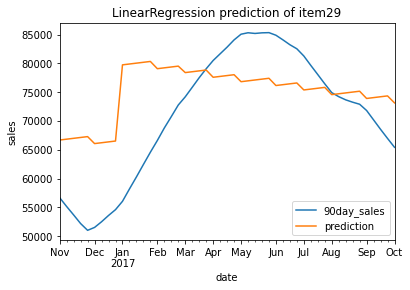

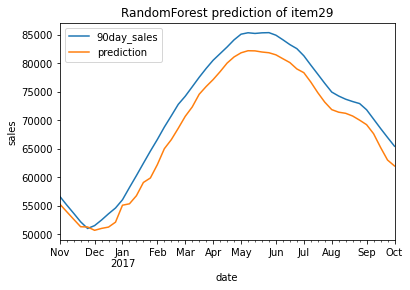

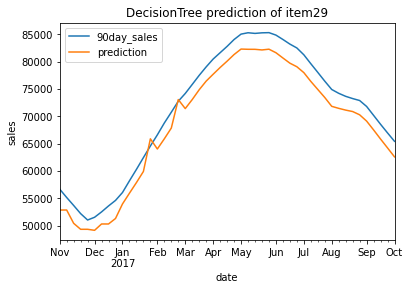

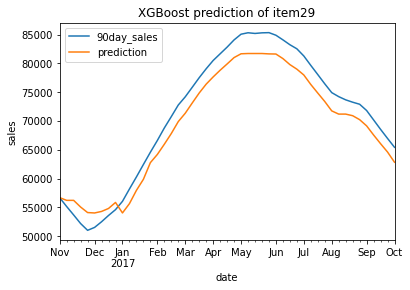

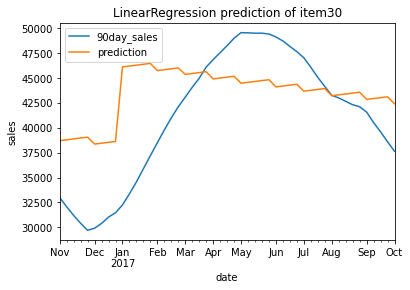

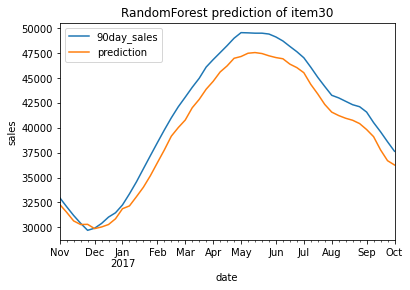

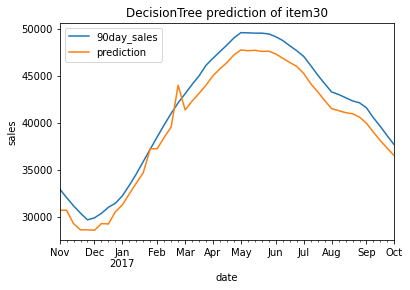

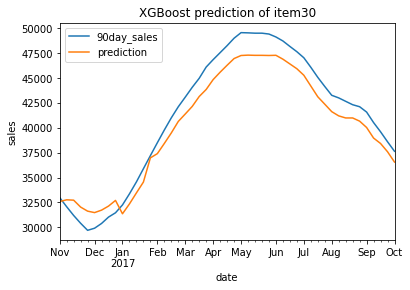

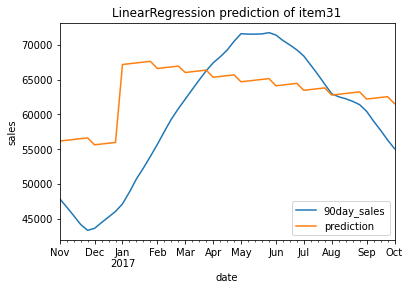

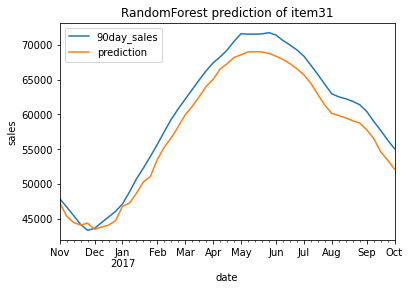

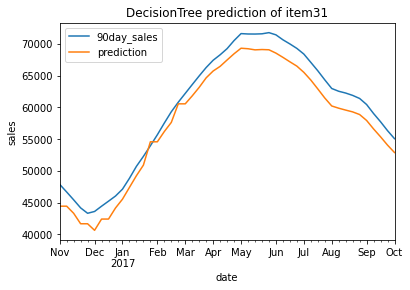

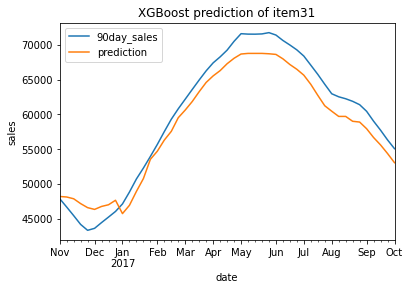

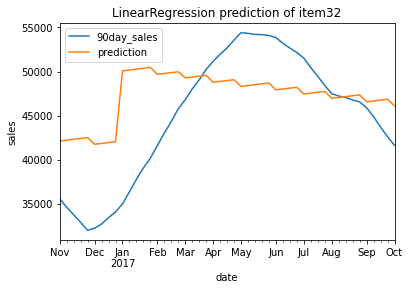

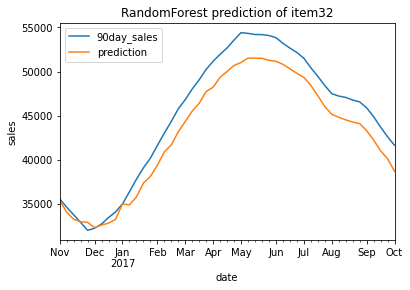

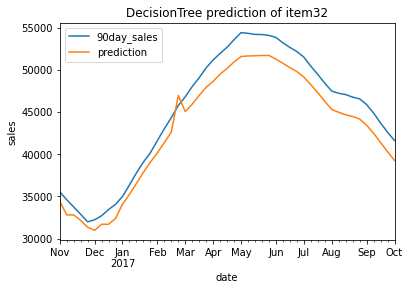

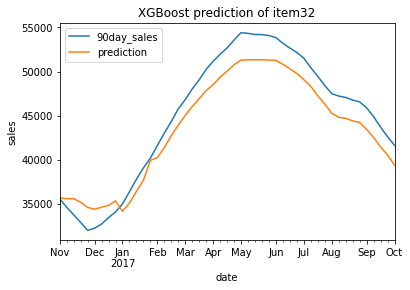

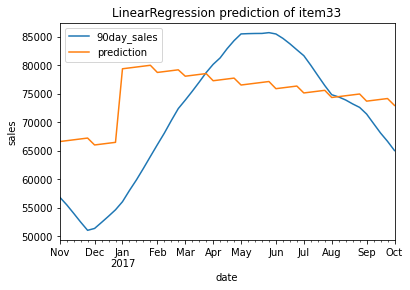

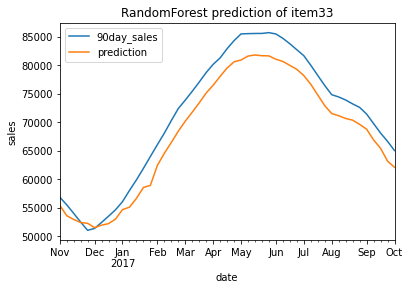

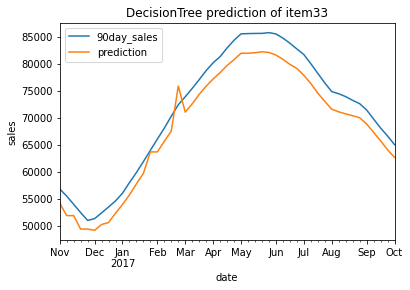

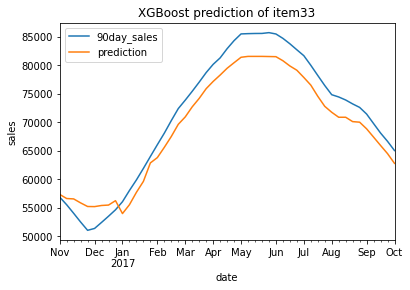

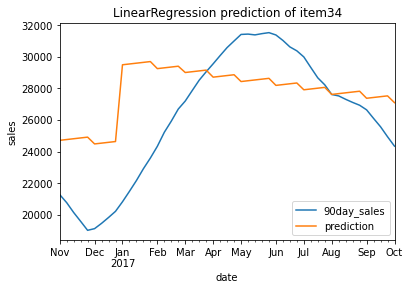

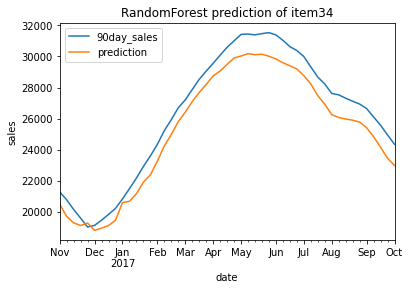

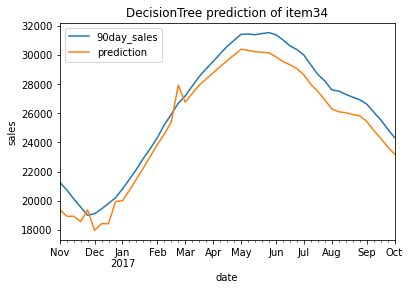

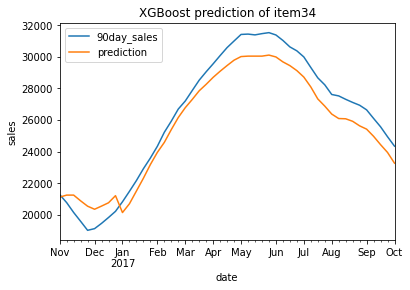

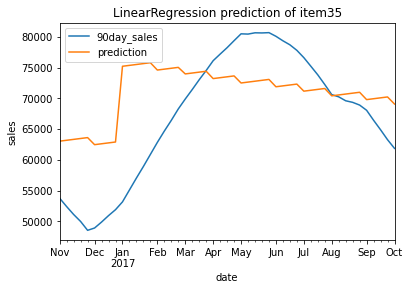

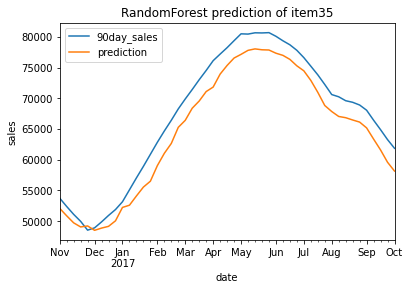

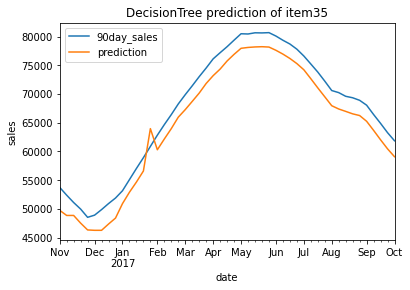

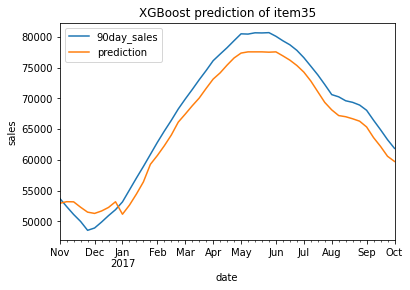

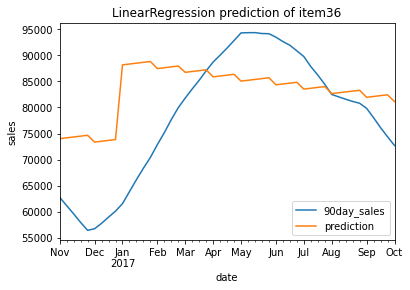

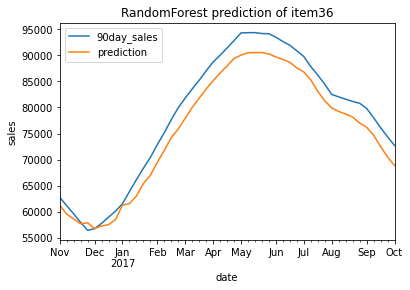

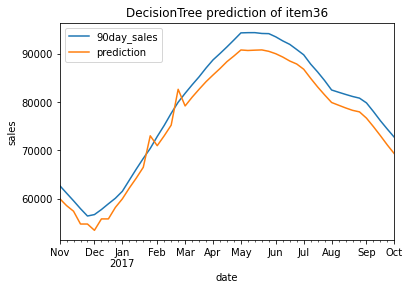

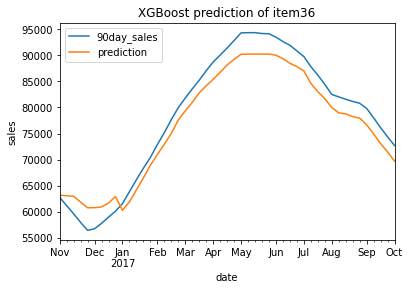

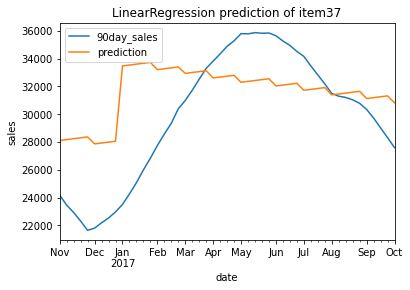

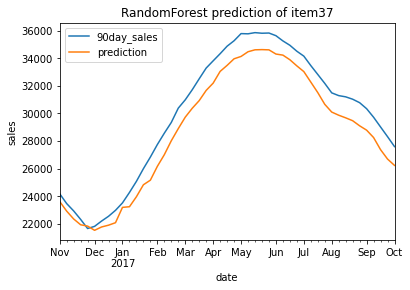

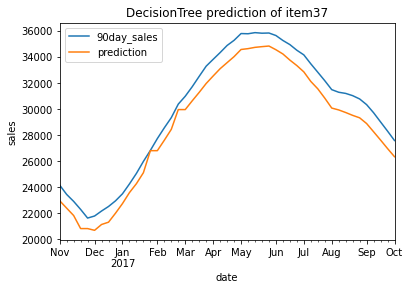

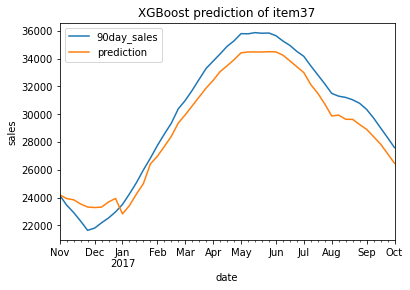

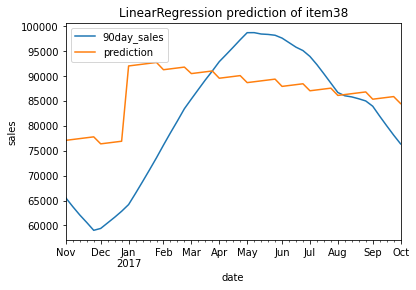

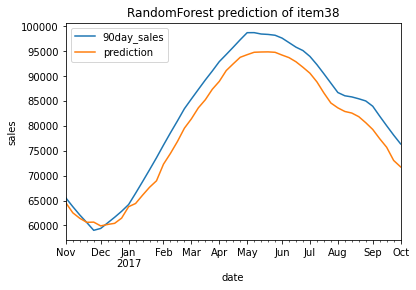

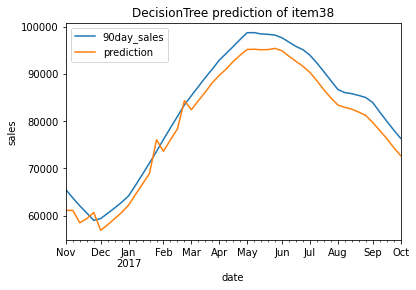

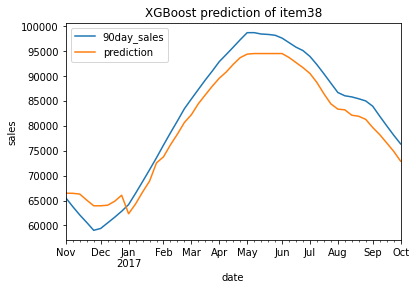

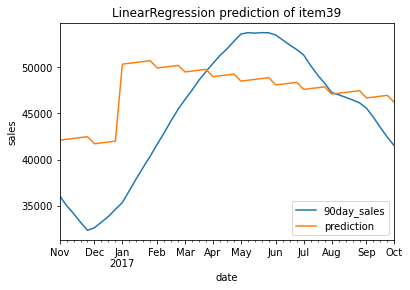

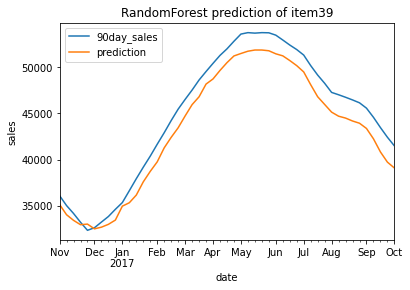

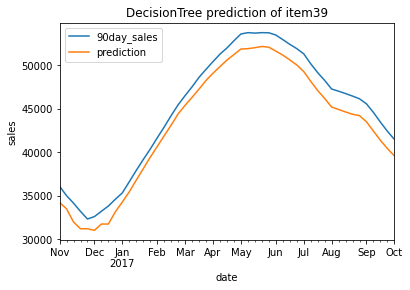

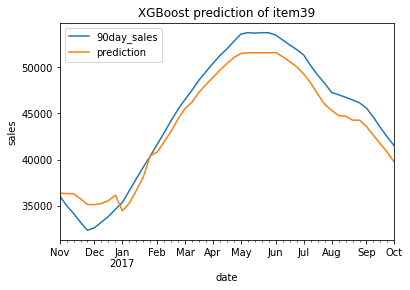

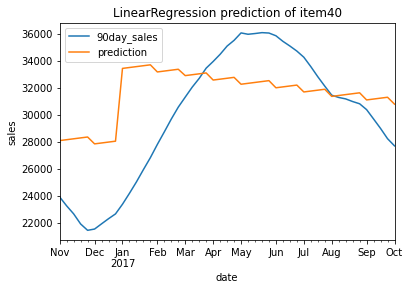

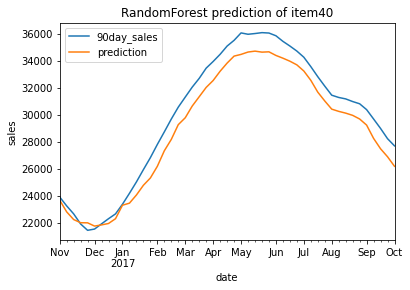

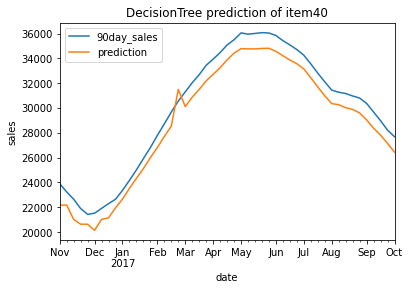

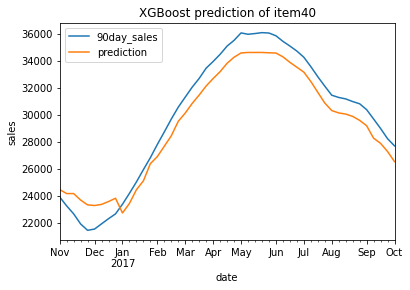

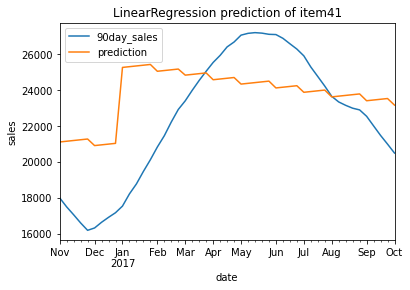

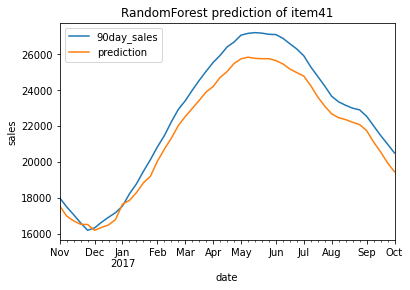

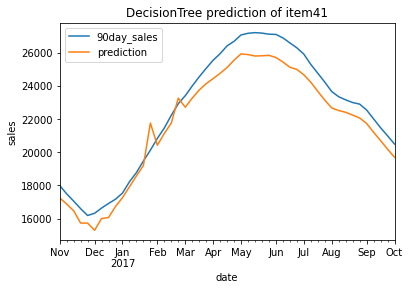

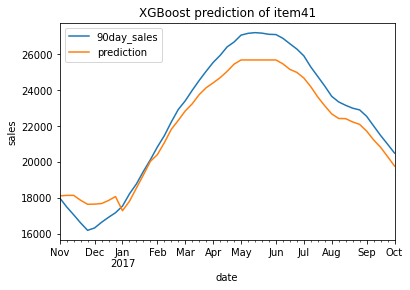

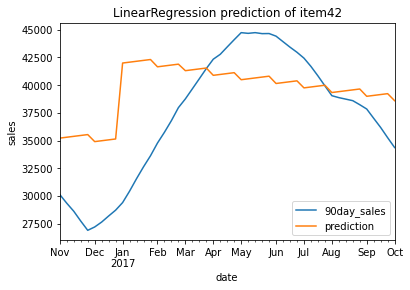

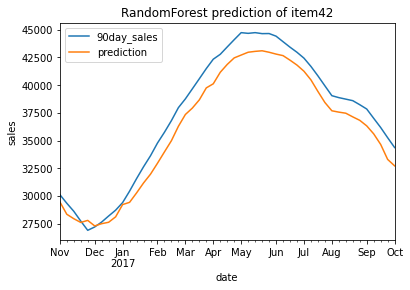

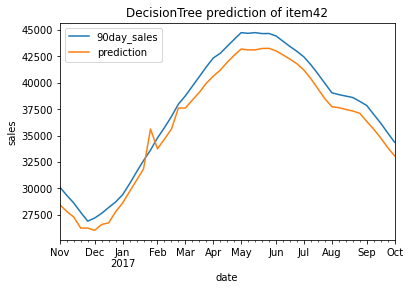

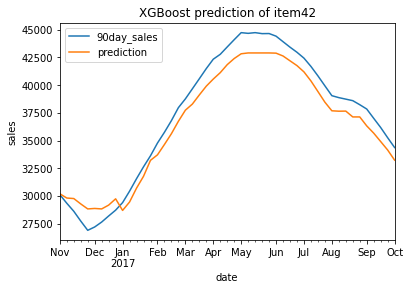

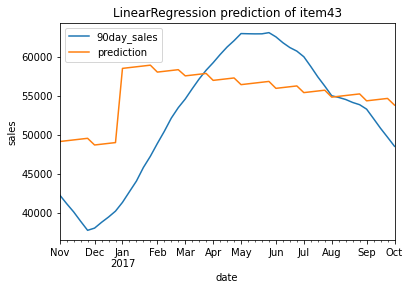

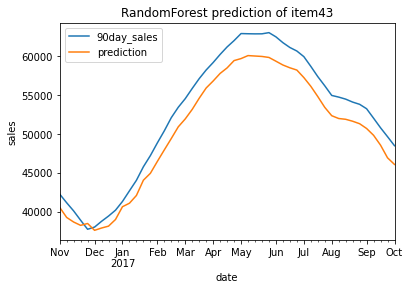

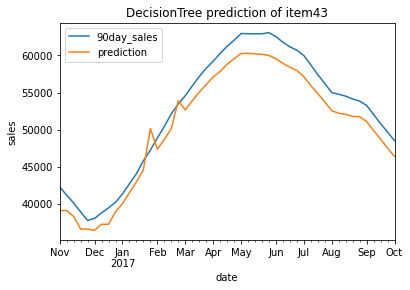

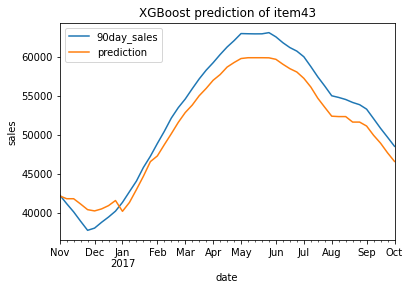

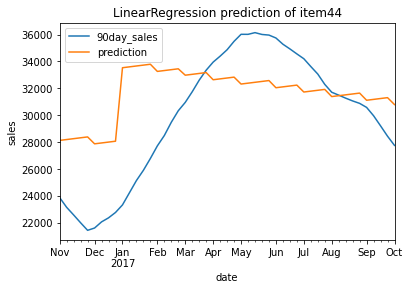

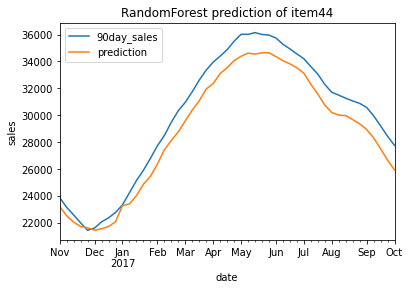

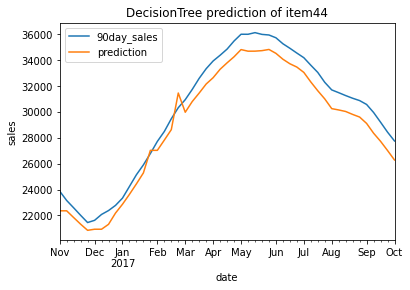

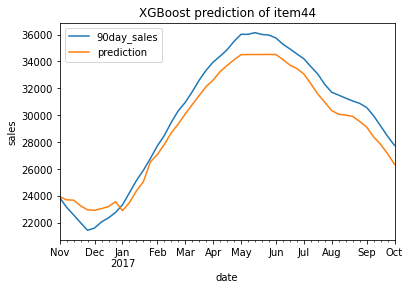

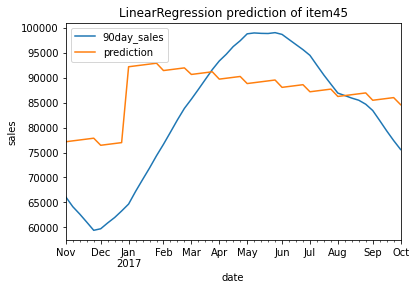

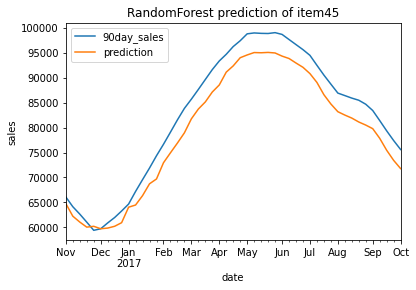

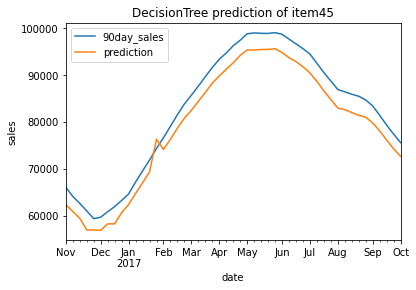

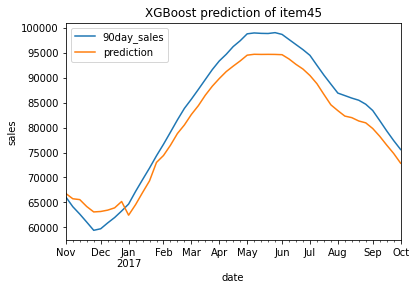

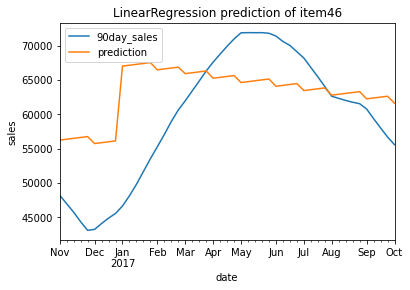

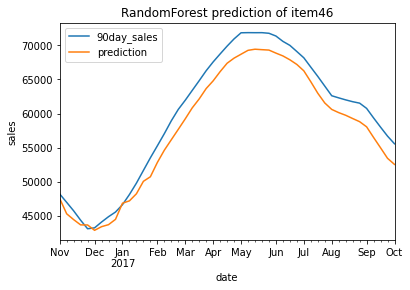

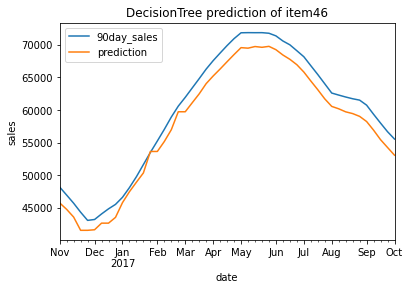

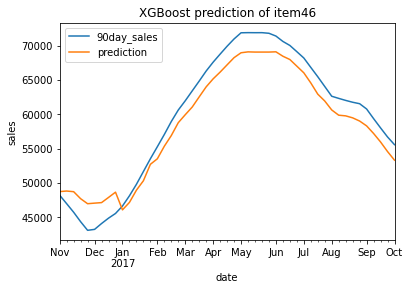

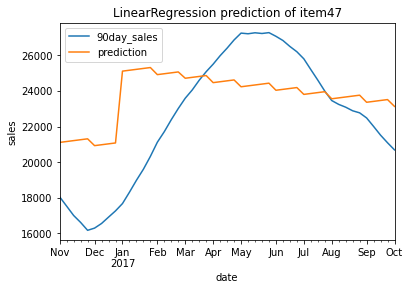

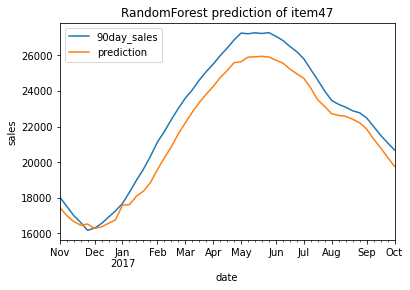

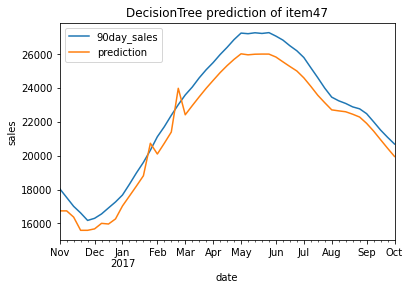

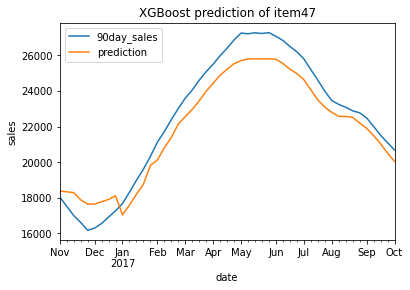

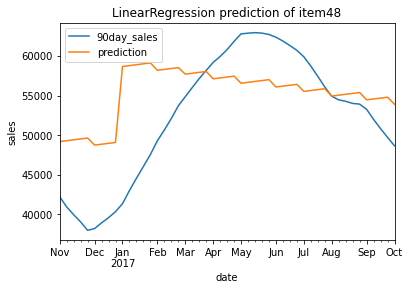

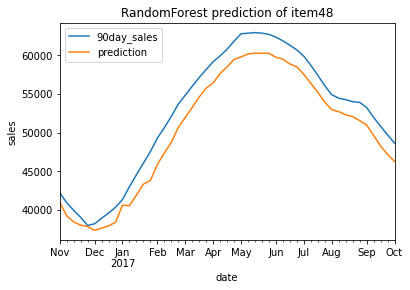

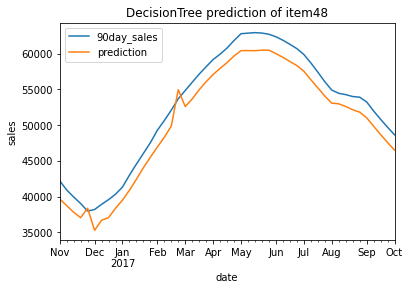

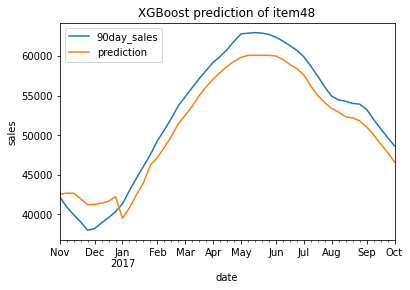

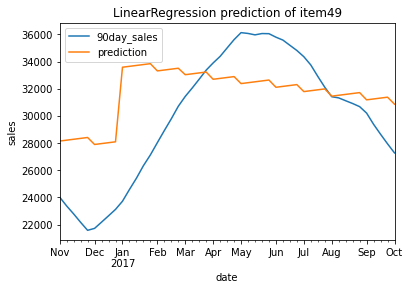

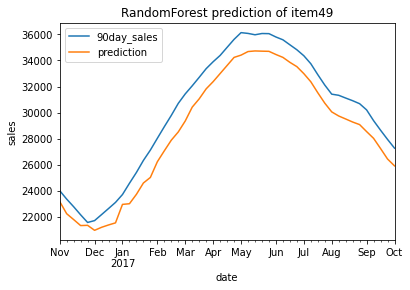

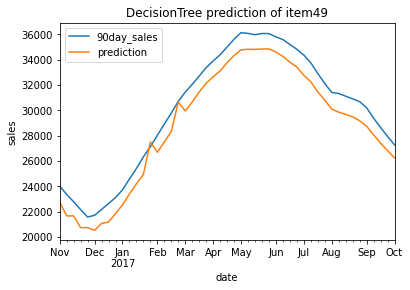

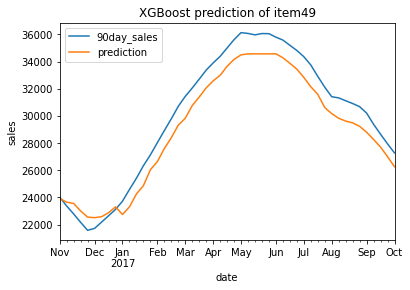

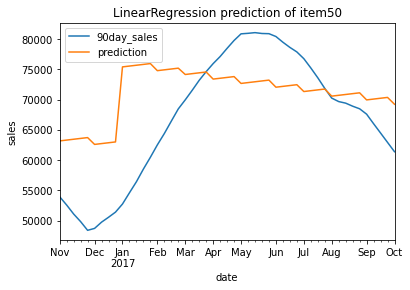

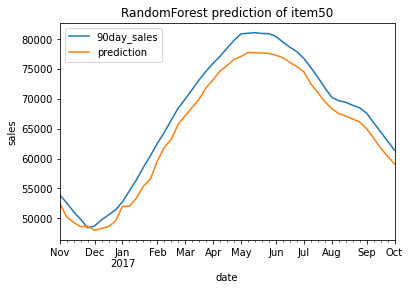

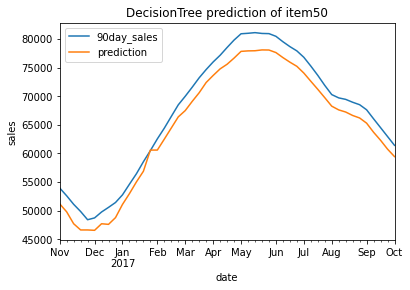

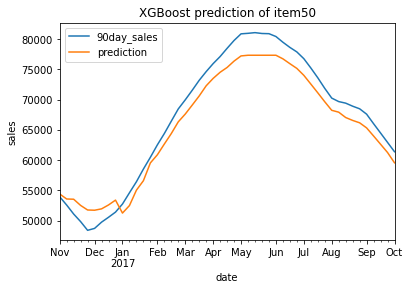

In [33]:
for i in range(1,51):
    df_item=d2[d2['item']==i]
    df_item['90day_sales']=df_item['sales'].rolling(90).sum()
    df_item=df_item.shift(-89)
    df_item=df_item.iloc[::7]
    df_item.drop(['item','sales'],axis=1,inplace=True)
    df_item# it gives information about next 90days sales data of item.
    
    df_item.reset_index(inplace=True)
    df_item['day']=df_item['date'].dt.day
    df_item['week']=df_item['date'].dt.week
    df_item['year']=df_item['date'].dt.year
    df_item.dropna(inplace=True)
    df_item.set_index('date',inplace=True)
    
    X_train=df_item.drop(['90day_sales'],axis=1).iloc[:200]
    X_test=df_item.drop(['90day_sales'],axis=1).iloc[200:]

    Y_train=df_item['90day_sales'].iloc[:200]
    Y_test=df_item['90day_sales'].iloc[200:]
    
    predict_plot(LinearRegression(),title='LinearRegression prediction of item'+str(i))
    predict_plot(RandomForestRegressor(),title='RandomForest prediction of item'+str(i))
    predict_plot(DecisionTreeRegressor(),title='DecisionTree prediction of item'+str(i))
    import xgboost as xgb
    xgb=xgb.XGBRegressor()
    predict_plot(xgb,title='XGBoost prediction of item'+str(i))
    
    
    k=r2.index(max(r2))
    print("The best r2_score for item"+str(i)+" achieved using",models[k],'and score is',max(r2))
    r2=[]
    best.append(l[k])
    l=[]